# News recommendation system

#### Name: Sivaprasad

### Objective

Recommend relevant news article content to users based on their preferences and interactions with a variety of news articles on the platform and based on what other similar users on the platform consume along with generating algorithms to predict similar news articles.

Two parts:
- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same


## Data pre-processing

In [81]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances 

from sklearn.preprocessing import MinMaxScaler
from numpy import *

from scipy.sparse import csr_matrix
import implicit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity

pd. set_option('display.max_rows', 500)
pd. set_option('display.max_columns', 500)
pd. set_option('display.width', 1000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\z0039jss\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [82]:
consumer_interaction = pd.read_csv("consumer_transanctions.csv")
platform_content = pd.read_csv("platform_content.csv")

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [83]:
consumer_interaction

event_timestamp  interaction_type              item_id          consumer_id   consumer_session_id                               consumer_device_info consumer_location country
0           1465413032   content_watched -3499919498720038879 -8845298781299428018   1264196770339959068                                                NaN               NaN     NaN
1           1465412560   content_watched  8890720798209849691 -1032019229384696495   3621737643587579081  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...                NY      US
2           1465416190   content_watched   310515487419366995 -1130272294246983140   2631864456530402479                                                NaN               NaN     NaN
3           1465413895  content_followed   310515487419366995   344280948527967603  -3167637573980064150                                                NaN               NaN     NaN
4           1465412290   content_watched -7820640624231356730  -445337111692715325  561148 1178424124714                                                NaN               NaN     NaN
...                ...               ...                  ...                  ...                   ...                                                ...               ...     ...
72307       1485190425     content_liked -6590819806697898649 -9016528795238256703   8614469745607949425  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...                MG      BR
72308       1485190425   content_watched -5813211845057621660   102305705598210278   5527770709392883642  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...                SP      BR
72309       1485190072   content_watched -1999468346928419252 -9196668942822132778  -8300596454915870873  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                SP      BR
72310       1485190434   content_watched -6590819806697898649 -9016528795238256703   8614469745607949425  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...                MG      BR
72311       1485187988   content_watched  5669290109546991426  5713241217519616260   6704552481483665372  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...                MG      BR

[72312 rows x 8 columns]

In [84]:
consumer_interaction.dtypes

event_timestamp          int64
interaction_type        object
item_id                  int64
consumer_id              int64
consumer_session_id     object
consumer_device_info    object
consumer_location       object
country                 object
dtype: object

In [85]:
consumer_interaction.interaction_type.unique()

array(['content_watched', 'content_followed', 'content_saved',
       'content_liked', 'content_commented_on'], dtype=object)

In [86]:
# creating 'ratings' column based on 'interaction_type' column
consumer_interaction['ratings'] = consumer_interaction.interaction_type.map({'content_followed': 5, 'content_commented_on' : 4, 'content saved':3,
                                           'content_liked': 2, 'content_watched': 1})

In [87]:
# taking relevant columns
consumer_interaction = consumer_interaction[['event_timestamp', 'item_id', 'interaction_type', 'consumer_id', 'ratings', 'consumer_location', 'country']]

In [88]:
# exploring platform_content
platform_content.head()

event_timestamp    interaction_type              item_id          producer_id  producer_session_id producer_device_info producer_location producer_country item_type                                           item_url                                              title                                   text_description language
0       1459192779  content_pulled_out -6451309518266745024  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
1       1459193988     content_present -4110354420726924665  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
2       1459194146     content_present -7292285110016212249  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://cointelegraph.com/news/bitcoin-future-w...  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en
3       1459194474     content_present -6151852268067518688  3891637997717104548 -1457532940883382585                  NaN               NaN              NaN      HTML  https://cloudplatform.googleblog.com/2016/03/G...                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en
4       1459194497     content_present  2448026894306402386  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  https://bitcoinmagazine.com/articles/ibm-wants...  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en

## EDA

In [89]:
consumer_interaction

event_timestamp              item_id  interaction_type          consumer_id  ratings consumer_location country
0           1465413032 -3499919498720038879   content_watched -8845298781299428018      1.0               NaN     NaN
1           1465412560  8890720798209849691   content_watched -1032019229384696495      1.0                NY      US
2           1465416190   310515487419366995   content_watched -1130272294246983140      1.0               NaN     NaN
3           1465413895   310515487419366995  content_followed   344280948527967603      5.0               NaN     NaN
4           1465412290 -7820640624231356730   content_watched  -445337111692715325      1.0               NaN     NaN
...                ...                  ...               ...                  ...      ...               ...     ...
72307       1485190425 -6590819806697898649     content_liked -9016528795238256703      2.0                MG      BR
72308       1485190425 -5813211845057621660   content_watched   102305705598210278      1.0                SP      BR
72309       1485190072 -1999468346928419252   content_watched -9196668942822132778      1.0                SP      BR
72310       1485190434 -6590819806697898649   content_watched -9016528795238256703      1.0                MG      BR
72311       1485187988  5669290109546991426   content_watched  5713241217519616260      1.0                MG      BR

[72312 rows x 7 columns]

In [90]:
# let's check the distribution
consumer_interaction.describe()

event_timestamp       item_id   consumer_id       ratings
count     7.231200e+04  7.231200e+04  7.231200e+04  69849.000000
mean      1.470103e+09 -3.033423e+16  1.252026e+16      1.232015
std       7.258130e+06  5.344755e+18  5.022333e+18      0.747193
min       1.457964e+09 -9.222795e+18 -9.223122e+18      1.000000
25%       1.464876e+09 -4.726309e+18 -3.596627e+18      1.000000
50%       1.468343e+09  1.893099e+16 -1.088422e+17      1.000000
75%       1.474461e+09  4.441012e+18  3.766319e+18      1.000000
max       1.488310e+09  9.222265e+18  9.210531e+18      5.000000

Mean rating is 1.23

In [91]:
# how many unique items?
consumer_interaction.item_id.nunique()

2987

In [92]:
consumer_interaction.interaction_type.value_counts() * 100 / len(consumer_interaction.interaction_type)

content_watched         84.475606
content_liked            7.944739
content_saved            3.406074
content_commented_on     2.227846
content_followed         1.945735
Name: interaction_type, dtype: float64

In [93]:
consumer_interaction.ratings.value_counts() * 100 / len(consumer_interaction.interaction_type)

1.0    84.475606
2.0     7.944739
4.0     2.227846
5.0     1.945735
Name: ratings, dtype: float64

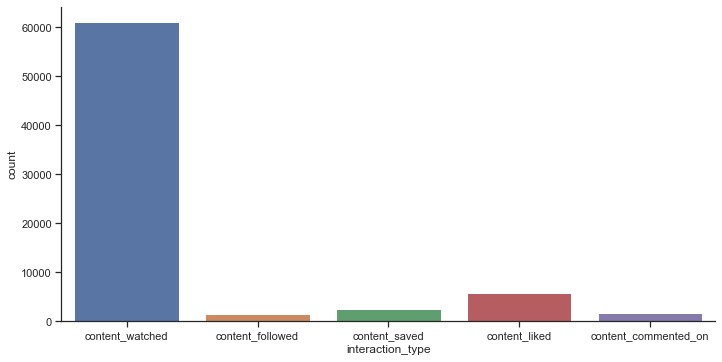

In [94]:
# distribution of interaction type
# Around 85% of the items are of rating 1 (content_watched)
sns.catplot(x="interaction_type", kind="count", height=5, aspect=2, data=consumer_interaction)

In [95]:
# Let's explore the consumer country and location
print(consumer_interaction.country.nunique())
print(consumer_interaction.country.unique())

23
[nan 'US' 'BR' 'JP' 'KR' 'IN' 'IE' 'SG' 'DE' 'CA' 'IS' 'AU' 'ZZ' 'ES' 'CN'
 'GB' 'MY' 'AR' 'NL' 'CL' 'IT' 'CO' 'PT' 'CH']


BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
SG       11
ZZ       11
AR        7
PT        6
IN        3
ES        3
IT        2
MY        2
CN        1
NL        1
CL        1
CO        1
CH        1
Name: country, dtype: int64


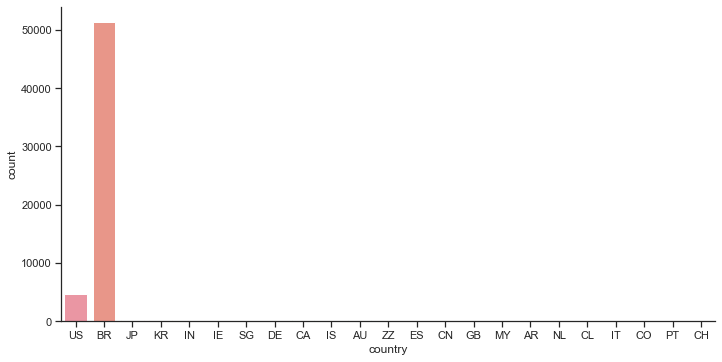

In [96]:
print(consumer_interaction.country.value_counts())
sns.catplot(x="country", kind="count", height=5, aspect=2, data=consumer_interaction)

Majority users are from BR and the US

In [97]:
consumer_interaction.consumer_location.unique()

array([nan, 'NY', 'MG', 'SP', 'RJ', 'GA', 'CA', '?', 'NJ', 'TX', '49',
       'MH', 'D', 'PA', 'VA', 'BE', 'AZ', 'IL', 'MI', 'FL', 'ES', 'BW',
       'MA', 'PR', 'BC', 'NSW', 'DF', 'C', 'HE', 'ON', 'MS', '13', '11',
       'DC', 'NE', 'NC', '33', 'CO', 'LA', 'ENG', 'GO', '14', 'IN', 'CT',
       '45', '27', 'WA', 'PE', 'MO', 'MN', 'RS', 'NH', '41', 'SC', 'BA',
       'WI', 'RM', 'OK', 'OH', 'CE', 'RI', 'AB', 'R', 'BOL', 'NV', 'OR',
       'KS', 'ZH', 'MT', 'QLD', 'PI', 'CL'], dtype=object)

In [98]:
consumer_interaction.consumer_location.value_counts()

SP     40164
MG     10229
NY      1257
TX       923
GA       910
RJ       775
NJ       698
?        327
CA       238
ON       202
NSW      135
IL       113
13       107
PR        88
MI        84
PA        76
FL        49
49        39
MA        39
ES        32
VA        30
CO        29
GO        23
ENG       22
AZ        20
BC        18
45        17
MS        17
KS        17
OH        16
DF        16
11        16
BA        14
D         12
BE        12
WA        11
DC        11
CT        10
PE        10
WI         9
C          8
SC         8
41         7
AB         6
BW         5
MO         5
LA         5
27         4
RS         4
OK         3
NE         3
QLD        3
MH         3
RI         3
NV         3
HE         2
IN         2
14         2
NC         2
RM         2
PI         2
NH         1
MT         1
CE         1
ZH         1
OR         1
BOL        1
MN         1
33         1
R          1
CL         1
Name: consumer_location, dtype: int64

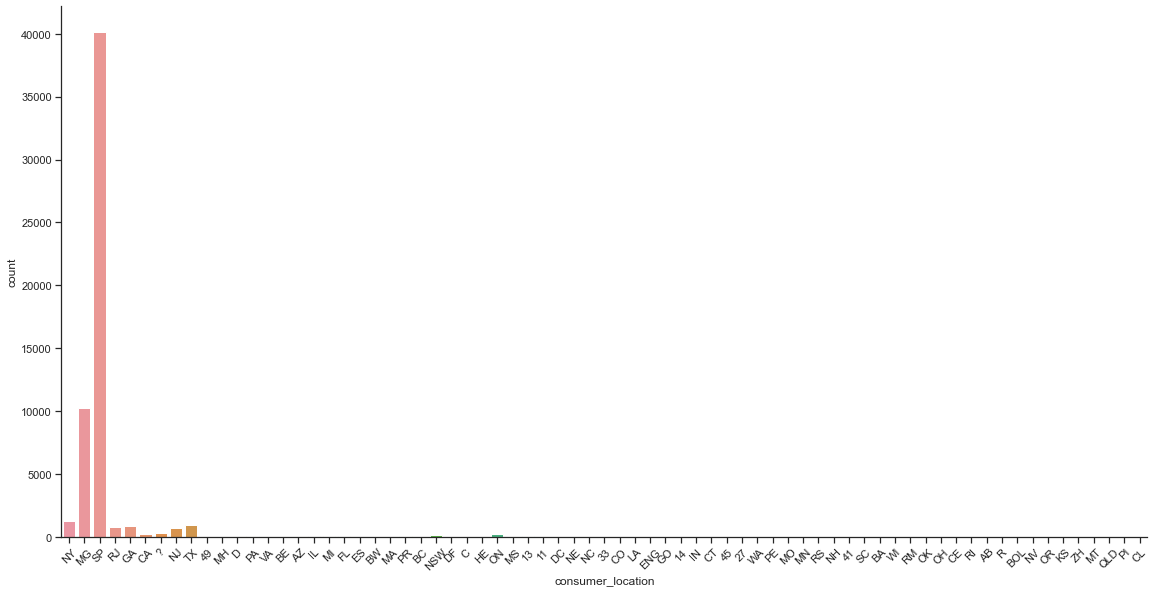

In [99]:
# let's plot the conumer location column
g = sns.catplot(x="consumer_location", kind="count", height=8, aspect=2, data=consumer_interaction)
g.set_xticklabels(rotation=45)



In [100]:
consumer_interaction

event_timestamp              item_id  interaction_type          consumer_id  ratings consumer_location country
0           1465413032 -3499919498720038879   content_watched -8845298781299428018      1.0               NaN     NaN
1           1465412560  8890720798209849691   content_watched -1032019229384696495      1.0                NY      US
2           1465416190   310515487419366995   content_watched -1130272294246983140      1.0               NaN     NaN
3           1465413895   310515487419366995  content_followed   344280948527967603      5.0               NaN     NaN
4           1465412290 -7820640624231356730   content_watched  -445337111692715325      1.0               NaN     NaN
...                ...                  ...               ...                  ...      ...               ...     ...
72307       1485190425 -6590819806697898649     content_liked -9016528795238256703      2.0                MG      BR
72308       1485190425 -5813211845057621660   content_watched   102305705598210278      1.0                SP      BR
72309       1485190072 -1999468346928419252   content_watched -9196668942822132778      1.0                SP      BR
72310       1485190434 -6590819806697898649   content_watched -9016528795238256703      1.0                MG      BR
72311       1485187988  5669290109546991426   content_watched  5713241217519616260      1.0                MG      BR

[72312 rows x 7 columns]

In [101]:
# Let's check for the duplicate entries.
consumer_interaction[consumer_interaction.duplicated(['item_id', 'consumer_id'])]

event_timestamp              item_id interaction_type          consumer_id  ratings consumer_location country
8           1465413762   310515487419366995  content_watched   344280948527967603      1.0               NaN     NaN
12          1465415228  3460026829794173084  content_watched  1908339160857512799      1.0                SP      BR
17          1465412288 -7820640624231356730  content_watched  -445337111692715325      1.0                MG      BR
20          1465416196   310515487419366995  content_watched -1130272294246983140      1.0                SP      BR
22          1465415060 -1492913151930215984  content_watched  4254153380739593270      1.0               NaN     NaN
...                ...                  ...              ...                  ...      ...               ...     ...
72305       1485187998   569574447134368517  content_watched -5230721907253934520      1.0                SP      BR
72306       1485190133  5484061377044071389  content_watched  3609194402293569455      1.0                SP      BR
72307       1485190425 -6590819806697898649    content_liked -9016528795238256703      2.0                MG      BR
72308       1485190425 -5813211845057621660  content_watched   102305705598210278      1.0                SP      BR
72310       1485190434 -6590819806697898649  content_watched -9016528795238256703      1.0                MG      BR

[31602 rows x 7 columns]

In [103]:
# Handling duplicates; Let's keep the row with max rating for the given combination of item & consumer.

consumer_interaction = pd.DataFrame(consumer_interaction.groupby(['item_id', 'consumer_id']).ratings.max()).reset_index()

In [104]:
consumer_interaction

item_id          consumer_id  ratings
0     -9222795471790223670 -6944500707172804068      2.0
1     -9222795471790223670 -5868110530814399805      5.0
2     -9222795471790223670 -1032019229384696495      5.0
3     -9222795471790223670  1895326251577378793      5.0
4     -9222795471790223670  8968131284214320024      2.0
...                    ...                  ...      ...
40705  9222265156747237864 -7540738139248278851      1.0
40706  9222265156747237864 -3596626804281480007      1.0
40707  9222265156747237864   692689608292948411      1.0
40708  9222265156747237864  2873028073541627603      1.0
40709  9222265156747237864  6464364285286199002      1.0

[40710 rows x 3 columns]

#### Explore plaform_content

In [105]:
# let's look at platform_content

platform_content.describe()


event_timestamp       item_id   producer_id  producer_session_id
count     3.122000e+03  3.122000e+03  3.122000e+03         3.122000e+03
mean      1.468804e+09  3.284110e+16  3.984819e+17         1.976675e+17
std       7.571512e+06  5.383734e+18  4.387115e+18         5.403753e+18
min       1.459193e+09 -9.222795e+18 -9.120686e+18        -9.212055e+18
25%       1.462369e+09 -4.660869e+18 -1.578288e+18        -4.651280e+18
50%       1.467136e+09  4.436584e+16 -7.092877e+17         4.154103e+17
75%       1.473873e+09  4.745617e+18  3.609194e+18         4.841644e+18
max       1.488308e+09  9.222265e+18  9.210531e+18         9.221043e+18

In [106]:
platform_content.head()

event_timestamp    interaction_type              item_id          producer_id  producer_session_id producer_device_info producer_location producer_country item_type                                           item_url                                              title                                   text_description language
0       1459192779  content_pulled_out -6451309518266745024  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
1       1459193988     content_present -4110354420726924665  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://www.nytimes.com/2016/03/28/business/dea...  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en
2       1459194146     content_present -7292285110016212249  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  http://cointelegraph.com/news/bitcoin-future-w...  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en
3       1459194474     content_present -6151852268067518688  3891637997717104548 -1457532940883382585                  NaN               NaN              NaN      HTML  https://cloudplatform.googleblog.com/2016/03/G...                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en
4       1459194497     content_present  2448026894306402386  4340306774493623681  8940341205206233829                  NaN               NaN              NaN      HTML  https://bitcoinmagazine.com/articles/ibm-wants...  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en

In [107]:
platform_content.language.value_counts()

en    2264
pt     850
la       4
ja       2
es       2
Name: language, dtype: int64

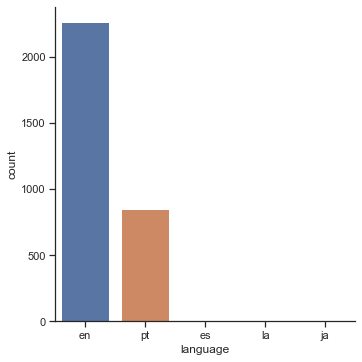

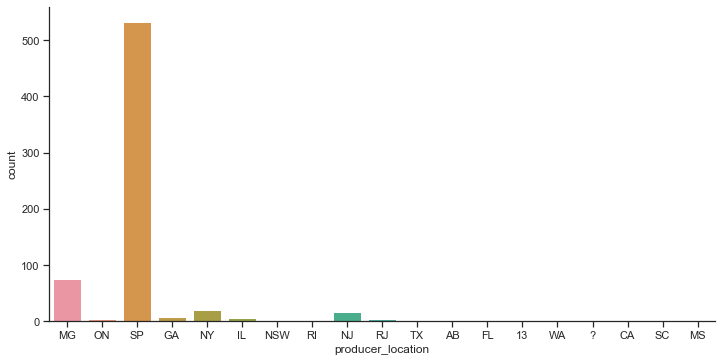

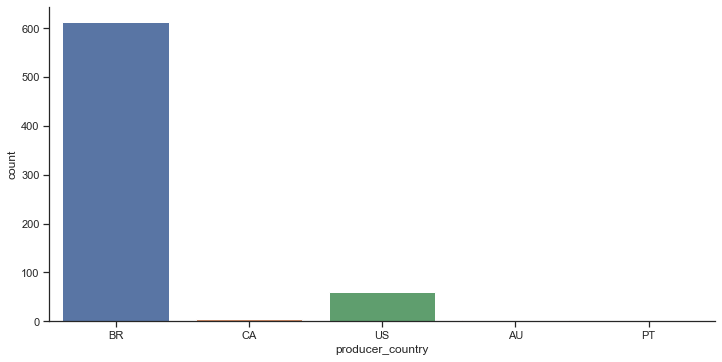

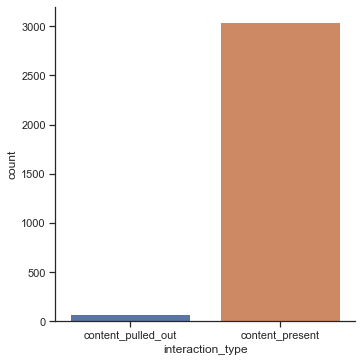

In [108]:
# Let's check the distributions
sns.catplot(x="language", kind="count", data=platform_content)
sns.catplot(x="producer_location", kind="count", height=5, aspect=2, data=platform_content)
sns.catplot(x="producer_country", kind="count", height=5, aspect=2, data=platform_content)
sns.catplot(x="interaction_type", kind="count", data=platform_content)

Most of the items are in english. There's a small chunk of content pulled off from the platform.

In [109]:
platform_content.item_type.nunique()

3

In [110]:
platform_content.item_type.unique()

array(['HTML', 'RICH', 'VIDEO'], dtype=object)

In [111]:
platform_content.item_url.nunique()

3029

In [112]:
# Total number of unique items in consumer_interactions
print(consumer_interaction.item_id.nunique())

print(platform_content.item_id.nunique())

print(platform_content.item_id.nunique() - consumer_interaction.item_id.nunique())

# Let's check if any item is missing in platform_content and present in consumer_interaction
platform_content_items = set(platform_content.item_id.unique())
consumer_items = set(consumer_interaction.item_id.unique())

len(platform_content_items & consumer_items)

2987
3057
70


2987

In [113]:
# list the items missing from consumer_interaction
set(platform_content.item_id.unique()) - set(consumer_interaction.item_id.unique())

{-8858741052589364245,
 -8531951303518498324,
 -8473322535064919980,
 -8294676699502353515,
 -8120372343967636100,
 -8112397019636931887,
 -8044741783031984918,
 -7904267039294833672,
 -7863574628164051955,
 -7814257818245609902,
 -7414654466964102039,
 -6275771337261603227,
 -5997023418322622504,
 -5968239566051821631,
 -5802731238371220572,
 -5623496706605874646,
 -4880614998012292765,
 -4291244850221551577,
 -3319960804317299025,
 -2880002165720705376,
 -2649418407515952078,
 -2309481887656981309,
 -2273517184910006534,
 -2148899391355011268,
 -1549326815285717811,
 -847494979958007433,
 -776023644693624658,
 -609005539129550395,
 -504935756748713175,
 -456161980484814803,
 -253149055249888078,
 -74919696966767903,
 5268351851132250,
 245828856632598563,
 476793294516827044,
 614512039577184122,
 756136904399885845,
 984451487666392184,
 1058260959930395162,
 1181375551449952059,
 1190376095547142533,
 1347061627677516149,
 1400543852157442197,
 1790561775815571583,
 202286947328041

In [114]:
set(consumer_interaction.item_id.unique()) - set(platform_content.item_id.unique())

set()

In [115]:
platform_content.interaction_type.value_counts()

content_present       3047
content_pulled_out      75
Name: interaction_type, dtype: int64

In [116]:
# encoding interaction type
# keeping only the necessary columns
platform_content['availability'] = platform_content['interaction_type'].map({'content_present': 1, 'content_pulled_out': 0})
platform_content = platform_content[['item_id', 'title', 'text_description', 'language', 'availability', 'item_url']]

In [117]:
platform_content

item_id                                              title                                   text_description language  availability                                           item_url
0    -6451309518266745024  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             0  http://www.nytimes.com/2016/03/28/business/dea...
1    -4110354420726924665  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             1  http://www.nytimes.com/2016/03/28/business/dea...
2    -7292285110016212249  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en             1  http://cointelegraph.com/news/bitcoin-future-w...
3    -6151852268067518688                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en             1  https://cloudplatform.googleblog.com/2016/03/G...
4     2448026894306402386  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en             1  https://bitcoinmagazine.com/articles/ibm-wants...
...                   ...                                                ...                                                ...      ...           ...                                                ...
3117  9213260650272029784  Conheça a Liga IoT, plataforma de inovação abe...  A Liga Ventures, aceleradora de startups espec...       pt             1  https://startupi.com.br/2017/02/liga-ventures-...
3118 -3295913657316686039  Amazon takes on Skype and GoToMeeting with its...  Amazon has launched Chime, a video conferencin...       en             1  https://thenextweb.com/apps/2017/02/14/amazon-...
3119  3618271604906293310                        Code.org 2016 Annual Report  February 9, 2017 - We begin each year with a l...       en             1                        https://code.org/about/2016
3120  6607431762270322325  JPMorgan Software Does in Seconds What Took La...  At JPMorgan Chase & Co., a learning machine is...       en             1  https://www.bloomberg.com/news/articles/2017-0...
3121  4109618890343020064               The 2017 Acquia Partners of the Year  The Acquia Partner Awards Program is comprised...       en             1  https://www.acquia.com/blog/partner/2017-acqui...

[3122 rows x 6 columns]

In [118]:
consumer_interaction

item_id          consumer_id  ratings
0     -9222795471790223670 -6944500707172804068      2.0
1     -9222795471790223670 -5868110530814399805      5.0
2     -9222795471790223670 -1032019229384696495      5.0
3     -9222795471790223670  1895326251577378793      5.0
4     -9222795471790223670  8968131284214320024      2.0
...                    ...                  ...      ...
40705  9222265156747237864 -7540738139248278851      1.0
40706  9222265156747237864 -3596626804281480007      1.0
40707  9222265156747237864   692689608292948411      1.0
40708  9222265156747237864  2873028073541627603      1.0
40709  9222265156747237864  6464364285286199002      1.0

[40710 rows x 3 columns]

In [119]:
# Filtering available english content 

platform_content = platform_content[(platform_content.language=='en') & (platform_content.availability==1)]

In [120]:
platform_content

item_id                                              title                                   text_description language  availability                                           item_url
1    -4110354420726924665  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             1  http://www.nytimes.com/2016/03/28/business/dea...
2    -7292285110016212249  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en             1  http://cointelegraph.com/news/bitcoin-future-w...
3    -6151852268067518688                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en             1  https://cloudplatform.googleblog.com/2016/03/G...
4     2448026894306402386  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en             1  https://bitcoinmagazine.com/articles/ibm-wants...
5    -2826566343807132236  IEEE to Talk Blockchain at Cloud Computing Oxf...  One of the largest and oldest organizations fo...       en             1  http://www.coindesk.com/ieee-blockchain-oxford...
...                   ...                                                ...                                                ...      ...           ...                                                ...
3116  4675505028897335428   Swift Top 10 Articles For The Past Year (v.2017)  For the past year , we've ranked nearly 9,000 ...       en             1  https://medium.mybridge.co/swift-top-10-articl...
3118 -3295913657316686039  Amazon takes on Skype and GoToMeeting with its...  Amazon has launched Chime, a video conferencin...       en             1  https://thenextweb.com/apps/2017/02/14/amazon-...
3119  3618271604906293310                        Code.org 2016 Annual Report  February 9, 2017 - We begin each year with a l...       en             1                        https://code.org/about/2016
3120  6607431762270322325  JPMorgan Software Does in Seconds What Took La...  At JPMorgan Chase & Co., a learning machine is...       en             1  https://www.bloomberg.com/news/articles/2017-0...
3121  4109618890343020064               The 2017 Acquia Partners of the Year  The Acquia Partner Awards Program is comprised...       en             1  https://www.acquia.com/blog/partner/2017-acqui...

[2211 rows x 6 columns]

## User based collaborative filtering

In [121]:
consumer_interaction_train, consumer_interaction_test = train_test_split(consumer_interaction, test_size=0.30, random_state=31)

### Modularized code

In [122]:

class UserBasedNewsRecommender:
    
    def __init__(self):
        self.isTrained = False    
        self.consumer_similarity_df = pd.DataFrame()
        self.item_prediction_df = pd.DataFrame()
        self.platform_content_df = pd.DataFrame()
        self.item_prediction_unseen_df = pd.DataFrame()

    def get_predictions(self):
        return self.item_prediction_df.copy()
    
    def fit(self, conumser_interactions_train, platform_content):
        
        self.data_matrix_train = conumser_interactions_train.pivot(
                                    index='consumer_id',
                                    columns='item_id',
                                    values='ratings'
                                ).fillna(0)
        consumer_similarity = 1 - pairwise_distances(self.data_matrix_train, metric='cosine')
        self.consumer_similarity_df = pd.DataFrame(consumer_similarity, 
                                              columns = self.data_matrix_train.index, 
                                              index = self.data_matrix_train.index)
        
        item_prediction = np.dot(consumer_similarity, self.data_matrix_train)
        self.item_prediction_df = pd.DataFrame(item_prediction, 
                                               columns=list(self.data_matrix_train.columns), 
                                               index=self.data_matrix_train.index)
        
        self.platform_content_df = platform_content
        
        dummy_train = self.data_matrix_train.copy()
        for c in dummy_train.columns:
            dummy_train[c] = dummy_train[c].apply(lambda x: 1.0 if x == 0.0 else 0.0)

        # to get only the unseen items
        self.item_prediction_unseen_df = np.multiply(item_prediction, dummy_train)        
        
        self.isTrained = True
        
        
    def recommend(self, consumer_id, K=10):

        if self.isTrained == False:
            print("Call fit() before recommend()!")
            return
        
        recommendations = self.item_prediction_unseen_df.loc[consumer_id]
        
        # inner join is to get the items available in platform_content (which are english and still available on the platform)
        merged = pd.merge(recommendations, 
                          self.platform_content_df,
                          on='item_id')
        
        print("Top {} recommendations for the consumer {}: ".format(K, consumer_id))
        output = merged.sort_values(by=[consumer_id], ascending=False)[0:K]
        output = output[['item_id', 'title', 'item_url', consumer_id]]
        output = output.rename(columns={consumer_id : 'recommendation_score'})
        return output.copy()
        
    
    def mae(self, consumer_interaction_test, consumer_interaction_train):
        
        if self.isTrained == False:
            print("Call fit() before mae()!")
            return
        
        common_ground_truth, predictions = self.__getGroundTruthAndPredictionsForCommonUsers(
                                                                consumer_interaction_test, 
                                                                consumer_interaction_train)
        predictions_arr = np.array(predictions)
        common_ground_truth_arr = np.array(common_ground_truth)
        
        predictions_arr = predictions_arr[common_ground_truth_arr.nonzero()]
        common_ground_truth_arr = common_ground_truth_arr[common_ground_truth_arr.nonzero()]
        
        print("Mean absolute error: ")
        print(mean_absolute_error(predictions_arr, common_ground_truth_arr))
    
    def rmse(self, consumer_interaction_test, consumer_interaction_train):
        
        if self.isTrained == False:
            print("Call fit() before rmse()!")
            return
        
        common_ground_truth, predictions = self.__getGroundTruthAndPredictionsForCommonUsers(
                                                                consumer_interaction_test, 
                                                                consumer_interaction_train)
        predictions_arr = np.array(predictions)
        common_ground_truth_arr = np.array(common_ground_truth)
        
        predictions_arr = predictions_arr[common_ground_truth_arr.nonzero()]
        common_ground_truth_arr = common_ground_truth_arr[common_ground_truth_arr.nonzero()]
        
        print("Root Mean Square Error: ")
        print(sqrt(mean_squared_error(predictions_arr, common_ground_truth_arr)))
    
    def global_average_precision_k(self, consumer_interaction_test, consumer_interaction_train, k=10):
        
        if self.isTrained == False:
            print("Call fit() before global_average_precision_k()!")
            return
    
        common_ground_truth, predictions_test_df = self.__getGroundTruthAndPredictionsForCommonUsers(
            consumer_interaction_test, consumer_interaction_train)
    
        global_precision = 0

        actual_data = common_ground_truth
        predicted_data = predictions_test_df
        for consumer in actual_data.index:

            actual = set(actual_data.loc[consumer].sort_values(ascending=False)[:k].index)
            predicted = set(predicted_data.loc[consumer].sort_values(ascending=False)[:k].index)

            precision_at_k = len(list(actual & predicted))/k
            global_precision = global_precision + precision_at_k

        global_average_precision = global_precision/actual_data.index.nunique()
        print("Global Average Precision@K, k={}: ".format(k))
        print(global_average_precision)    
        
    def __getGroundTruthAndPredictionsForCommonUsers(self, consumer_interaction_test, consumer_interaction_train):
  
        # To form the prediction and ground truth, we need to filter common users. 
        # This will be used to filter the similarities of the common users. 
        # Ground truth is the pivot table created using these common users.
        # Prediction matrix is obtained by multiplying the common user similarity matrix and ground truth.

        common_test = consumer_interaction_test[consumer_interaction_test.consumer_id.isin(consumer_interaction_train.consumer_id)]
        common_ground_truth = common_test.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0)
        
        # Get the users in the test data
        list_name_test = common_test.consumer_id.tolist()


        consumer_similarity_test = self.consumer_similarity_df[self.consumer_similarity_df.index.isin(list_name_test)]
        consumer_similarity_test = consumer_similarity_test.T[consumer_similarity_test.T.index.isin(list_name_test)]
        consumer_similarity_test = consumer_similarity_test.T

        predictions_test = np.dot(consumer_similarity_test, common_ground_truth.fillna(0))
        predictions_test_df = pd.DataFrame(predictions_test, index=common_ground_truth.index, columns=common_ground_truth.columns)
        
        return common_ground_truth.copy(), predictions_test_df.copy()        

In [123]:
ubcf_rec = UserBasedNewsRecommender()

ubcf_rec.fit(consumer_interaction_train, platform_content)

In [124]:
# Recommend articles
ubcf_rec.recommend(-9212075797126931087)

Top 10 recommendations for the consumer -9212075797126931087: 


item_id                                              title                                           item_url  recommendation_score
585  -4084394822880420062                                 Android Studio 2.2  http://android-developers.blogspot.com.br/2016...              1.491829
565  -4228415104574264137  Up your app's sharing game with DirectShare - ...  https://medium.com/google-developers/up-your-a...              1.390860
591  -4029704725707465084  Former Google career coach shares a visual tri...  http://www.cnbc.com/2016/12/21/former-google-c...              1.152252
148  -7986975759046428357                                    It's The Future          https://circleci.com/blog/its-the-future/              1.079328
275  -6728844082024523434                                          Seniority            http://merowing.info/2017/01/seniority/              1.051655
351  -6076367233589223323             Android Developers Summer Reading List  https://realm.io/news/android-developer-summer...              1.028447
194  -7518373517401484139  My favorite people and resources to learn Andr...  https://m.signalvnoise.com/my-favorite-people-...              1.005445
284  -6654470039478316910                          Advanced Android Espresso  https://realm.io/news/chiu-ki-chan-advanced-an...              0.920764
633  -3700095596785790870   How to Design a Walkthrough That Users Will Read  http://uxmovement.com/mobile/how-to-design-a-w...              0.911429
1957  8297658253225035519  Final Developer Preview before Android 7.0 Nou...  http://android-developers.blogspot.com.br/2016...              0.847030

### Evaluation

In [125]:

ubcf_rec.mae(consumer_interaction_test, consumer_interaction_train)

Mean absolute error: 
0.5923648344881998


In [126]:
ubcf_rec.rmse(consumer_interaction_test, consumer_interaction_train)

Root Mean Square Error: 
0.8940209682778476


In [127]:
# Let's check the global average precision@K for common users
ubcf_rec.global_average_precision_k(consumer_interaction_test, consumer_interaction_train, 10)

Global Average Precision@K, k=10: 
0.2697368421052636


## Item based collaborative filtering

### Modularized code

In [128]:
class ItemBasedNewsRecommender:
    
    def __init__(self):
        self.isTrained = False    
        self.item_similarity_df = pd.DataFrame()
        self.item_prediction_df = pd.DataFrame()
        self.platform_content_df = pd.DataFrame()
        self.item_prediction_unseen_df = pd.DataFrame()

    def get_item_correlation(self):
        return self.item_similarity_df.copy()
    
    def fit(self, conumser_interactions_train, platform_content):
        
        self.data_matrix_train = conumser_interactions_train.pivot(
                                    index='consumer_id',
                                    columns='item_id',
                                    values='ratings'
                                ).fillna(0)
        self.data_matrix_train = self.data_matrix_train.T
        
        item_similarity = 1 - pairwise_distances(self.data_matrix_train, metric='cosine')
        self.item_similarity_df = pd.DataFrame(item_similarity, 
                                              columns = self.data_matrix_train.index, 
                                              index = self.data_matrix_train.index)     
        
        self.platform_content_df = platform_content
        self.isTrained = True
        
        
    def get_similar_items(self, item_id):

        if self.isTrained == False:
            print("Call fit() before recommend()!")
            return
        
        d = self.item_similarity_df.loc[item_id]
        
        # inner join is to get the items available in platform_content (which are english and still available on the platform)
        item_merged = pd.merge(d, self.platform_content_df, on='item_id')
        
        # first item is the input item, which is not required to be recommended again
        output = item_merged.sort_values(by=[item_id], ascending=False)[1:]
        output = output[['item_id','title', item_id, 'item_url']]
        
        output = output.rename(columns={item_id : "item_sim_score"})
        
        return output.copy()
        
    
    def mae(self, consumer_interaction_test, consumer_interaction_train):
        
        if self.isTrained == False:
            print("Call fit() before mae()!")
            return
        
        common_ground_truth, predictions = self.__getGroundTruthAndPredictionsForCommonUsers(
                                                                consumer_interaction_test, 
                                                                consumer_interaction_train)
        predictions_arr = np.array(predictions)
        common_ground_truth_arr = np.array(common_ground_truth)
        
        predictions_arr = predictions_arr[common_ground_truth_arr.nonzero()]
        common_ground_truth_arr = common_ground_truth_arr[common_ground_truth_arr.nonzero()]
        
        print("Mean absolute error: ")
        print(mean_absolute_error(predictions_arr, common_ground_truth_arr))
    
    def rmse(self, consumer_interaction_test, consumer_interaction_train):
        
        if self.isTrained == False:
            print("Call fit() before rmse()!")
            return
        
        common_ground_truth, predictions = self.__getGroundTruthAndPredictionsForCommonUsers(
                                                                consumer_interaction_test, 
                                                                consumer_interaction_train)
        predictions_arr = np.array(predictions)
        common_ground_truth_arr = np.array(common_ground_truth)
        
        predictions_arr = predictions_arr[common_ground_truth_arr.nonzero()]
        common_ground_truth_arr = common_ground_truth_arr[common_ground_truth_arr.nonzero()]
        
        print("Root Mean Square Error: ")
        print(sqrt(mean_squared_error(predictions_arr, common_ground_truth_arr)))
    
    def global_average_precision_k(self, consumer_interaction_test, consumer_interaction_train, k=10):
        
        if self.isTrained == False:
            print("Call fit() before global_average_precision_k()!")
            return
    
        common_ground_truth, predictions_test_df = self.__getGroundTruthAndPredictionsForCommonUsers(
            consumer_interaction_test, consumer_interaction_train)
    
        global_precision = 0

        actual_data = common_ground_truth
        predicted_data = predictions_test_df
        for consumer in actual_data.index:

            actual = set(actual_data.loc[consumer].sort_values(ascending=False)[:k].index)
            predicted = set(predicted_data.loc[consumer].sort_values(ascending=False)[:k].index)

            precision_at_k = len(list(actual & predicted))/k
            global_precision = global_precision + precision_at_k

        global_average_precision = global_precision/actual_data.index.nunique()
        print("Global Average Precision@K, k={}: ".format(k))
        print(global_average_precision)    
        
    def __getGroundTruthAndPredictionsForCommonUsers(self, consumer_interaction_test, consumer_interaction_train):
  
        # To form the prediction and ground truth, we need to filter common users. 
        # This will be used to filter the similarities of the common users. 
        # Ground truth is the pivot table created using these common users.
        # Prediction matrix is obtained by multiplying the common user similarity matrix and ground truth.

        common_test = consumer_interaction_test[consumer_interaction_test.item_id.isin(consumer_interaction_train.item_id)]
        common_ground_truth = common_test.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0).T
        
        # Get the users in the test data
        list_item = common_test.item_id.tolist()


        item_similarity_df_1 = self.item_similarity_df[self.item_similarity_df.index.isin(list_item)]
        item_similarity_df_2 = item_similarity_df_1.T[item_similarity_df_1.T.index.isin(list_item)]
        item_similarity_df_3 = item_similarity_df_2.T
        
        predictions_test = np.dot(item_similarity_df_3, common_ground_truth.fillna(0))
        
        predictions_test_df = pd.DataFrame(predictions_test, index=common_ground_truth.index, columns=common_ground_truth.columns)
        
        return common_ground_truth.copy(), predictions_test_df.copy() 

In [129]:
ibcf_rec = ItemBasedNewsRecommender()

In [130]:
ibcf_rec.fit(consumer_interaction_train, platform_content)

In [131]:
#ibcf_rec.get_similar_items(-9190737901804729417)
ibcf_rec.get_similar_items(-6151852268067518688)

item_id                                              title  item_sim_score                                           item_url
296  -6566328419164841526  Feeding 10 billion people with cloud computing...        0.628971  https://cloudplatform.googleblog.com/2016/05/f...
1250  2271793263120018251  Artificial Intelligence Can Now Design Realist...        0.605406  https://www.technologyreview.com/s/601258/arti...
1199  1662917027785920354  Gchat Was the Future of Messaging, But Google ...        0.588348  http://www.slate.com/blogs/future_tense/2016/0...
1194  1595230810451459837             Event Map For Google I/O 2016 Released        0.579365  http://www.androidpolice.com/2016/04/28/event-...
82   -8615008595949058842  Restb.ai: Why custom computer vision as a serv...        0.576557  http://www.zdnet.com/article/restb-ai-why-cust...
...                   ...                                                ...             ...                                                ...
868  -1324705355456975418   4 essential how-tos for dealing with scope creep        0.000000  http://blogs.atlassian.com/2015/09/4-how-tos-d...
867  -1342820011354825290  CMO interview: Putting IBM's marketing technol...        0.000000  http://www.cmo.com.au/article/600729/cmo-inter...
866  -1365928983118861754  Practical guide to PaaS: Benefits and characte...        0.000000  https://www.ibm.com/blogs/cloud-computing/2016...
865  -1403735753867098241                   The "Joel Test" for Data Science        0.000000  https://blog.dominodatalab.com/joel-test-data-...
2071  9222265156747237864  Deep-learning neural network creates its own i...        0.000000  http://www.extremetech.com/extreme/227287-deep...

[2071 rows x 4 columns]

### Evaluation

In [132]:
ibcf_rec.mae(consumer_interaction_test, consumer_interaction_train)

Mean absolute error: 
3.7286012124557373


In [133]:
ibcf_rec.rmse(consumer_interaction_test, consumer_interaction_train)

Root Mean Square Error: 
7.562013844950922


In [134]:
# Let's check the Global Average Precision @ K

ibcf_rec.global_average_precision_k(consumer_interaction_test, consumer_interaction_train, 10)

Global Average Precision@K, k=10: 
0.12863087806907966


## Content based collaborative filtering

### Modularized code

In [135]:
class ContentBasedNewRecommender:
    
    def __init__(self):
        self.item_similarity_matrix = []
        self.tfidf = TfidfModel()
        self.paltform_content_en = pd.DataFrame()
        self.dictionary = Dictionary()
    
    def fit(self, platform_content):
        
        # filter english items
        self.paltform_content_en = platform_content
        
        keywords_array = (self.paltform_content_en['text_description'] + self.paltform_content_en['title']).to_numpy() 
        
        words_list = self.__preprocess(keywords_array)
        
        # create a dictionary from words list
        self.dictionary = Dictionary(words_list) 

        #create corpus where the corpus is a bag of words for each document
        corpus = [self.dictionary.doc2bow(doc) for doc in words_list] 

        #create tfidf model of the corpus
        self.tfidf = TfidfModel(corpus) 

        # Create the similarity matrix. This is the most important part where we get the similarities between the items.
        self.item_similarity_matrix = MatrixSimilarity(self.tfidf[corpus], num_features=len(self.dictionary))
    
    def __preprocess(self, keywords_array):
        
        words_list = []
        stop_words = stopwords.words("english")
        
        # remove stop words and punctuations
        stop_words.extend(['$', "'", "''", "'s", ',', '-', '.',':', '``', '!', '@', '#', '(', ')', '%', '^', '&', '*', '_', ':', ';'])

        for keyword in keywords_array:
            keyword = keyword.lower()

            # let's get each token and corresponding pos tag
            # Pos tag will be used to lemmatize the token
            words = nltk.pos_tag(word_tokenize(keyword))

            wordnet_lemmatizer = WordNetLemmatizer()

            words_updated = []
            for word in words:
                if word[0] not in stop_words:  
                    words_updated.append(wordnet_lemmatizer.lemmatize(word[0], pos=self.__nltk_tag_to_wordnet_tag(word[1])))

            words_list.append(words_updated)   
            
        return words_list
    
    def __nltk_tag_to_wordnet_tag(self, nltk_tag):
        
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        
        else:          
            return wordnet.NOUN
    
    def recommend(self, item_title):
        
        # get the item row
        item_row = self.paltform_content_en.loc[self.paltform_content_en.title==item_title] 
        
        if len(item_row) == 0:
            raise ValueError("Unknown item!")
        
        #split the keywords
        keywords = self.__preprocess(item_row['text_description'] + item_row['title'])
        
        #set the list of words to query_doc
        query_doc = keywords[0] 

        # get a bag of words from the query_doc
        query_doc_bow = self.dictionary.doc2bow(query_doc) 

        #convert the regular bag of words model to a tf-idf model
        query_doc_tfidf = self.tfidf[query_doc_bow] 

        # get similarity values between input item and all other items
        similarity_array = self.item_similarity_matrix[query_doc_tfidf] 

        #Convert to a df
        similarity_series = pd.Series(similarity_array.tolist(), index=self.paltform_content_en.title.values) 

        similarity_series_df = pd.DataFrame({"item_id": self.paltform_content_en.item_id,
                                             "title" : self.paltform_content_en.title.values, 
                                             "content_sim_score": similarity_array.tolist()})
        #get the most similar items 
        similarity_series_df = similarity_series_df.sort_values(by=["content_sim_score"], ascending=False)

        # first item is always the input item, which is not required to be recommended again.
        return similarity_series_df[1:]
        

In [136]:
cb_rec = ContentBasedNewRecommender()

In [137]:
platform_content.shape

(2211, 6)

In [138]:
cb_rec.fit(platform_content)

In [139]:
cb_rec.recommend('Google Data Center 360° Tour')

item_id                                              title  content_sim_score
906   4563606877148407012  YouTube's New Messenger Means You'll Never Hav...           0.277748
142   8298709454703868984  Google shares data center security and design ...           0.249599
676   8596997246990922861                       This year's Founders' Letter           0.232671
2885  6009447229221815725  [Tools] How to Record your Desktop Screen with...           0.191213
547  -7586203274767893481  Top 5 GCP NEXT breakout sessions on YouTube (s...           0.165491
...                   ...                                                ...                ...
516   -582471538642477927        Authenticated User Page Caching (Authcache)           0.000000
2646  3385087622593663739                           Captain Fantastic (2016)           0.000000
1351  5714055337338770799  ""Good Luck with That!": Teaching Machines to ...           0.000000
2387  1525777409079968377                          Probabilistic Programming           0.000000
3121  4109618890343020064               The 2017 Acquia Partners of the Year           0.000000

[2210 rows x 3 columns]

## ALS

### Modularized code

In [140]:
from implicit.evaluation import train_test_split

In [301]:
class ALSNewsRecommender:
    
    def __init__(self):
        self.sparse_item_user = object
        self.als_model = object
        
        self.unique_items_idx_dict_df = pd.DataFrame()
        self.unique_consumer_idx_dict_df = pd.DataFrame()
        
    def get_sparse_item_user(self):
        return self.sparse_item_user.copy()
    
    def create_sparse_item_user(self, consumer_interaction):
        
        # csr_matrix cannot be created using negative indices. 
        # To handle that, let's map consumer ids and items ids to positive values

        unique_items = list(consumer_interaction.item_id.unique())
        unique_consumers = list(consumer_interaction.consumer_id.unique())

        items_indices = list(range(0, len(unique_items)))
        consumer_indices = list(range(0, len(unique_consumers)))


        self.unique_items_idx_dict_df = pd.DataFrame({'item_id': unique_items, 
                                         'item_idx': items_indices })

        self.unique_consumer_idx_dict_df = pd.DataFrame({'consumer_id': unique_consumers, 
                                         'consumer_idx': consumer_indices })
        
        # Let's merge

        self.consumer_interaction_with_idx = pd.merge(consumer_interaction, self.unique_items_idx_dict_df, on='item_id', how='left')
        self.consumer_interaction_with_idx = pd.merge(self.consumer_interaction_with_idx, self.unique_consumer_idx_dict_df, on='consumer_id', how='left')
        
        alpha = 40
        sparse_user_item = csr_matrix(([alpha] * self.consumer_interaction_with_idx.shape[0], 
                                        (self.consumer_interaction_with_idx['consumer_idx'], self.consumer_interaction_with_idx['item_idx'])))
        
        self.sparse_item_user = sparse_user_item.T.tocsr()
        return self.sparse_item_user.copy()
        
    def split_sparse_item_user(self, train_percentage=0.8):
    
        return implicit.evaluation.train_test_split(self.sparse_item_user, train_percentage=0.8)
    
    # Best precision@K was obtained with the following parameters, so let's keep them as default
    # iterations:100, regularization: 0.01, factors: 100 : 0.13781676413255362
    def fit(self, 
            sparse_item_user_train, 
            factors = 100, 
            regularization=0.01,
            iterations=100,
            calculate_training_loss=True):
        
        self.als_model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                         regularization=regularization,
                                                         iterations=iterations, 
                                                         calculate_training_loss=calculate_training_loss)
        
        # train als model
        self.als_model.fit(sparse_item_user_train)
        
    def recommend(self, consumer_id):
        user_idx = self.unique_consumer_idx_dict_df[self.unique_consumer_idx_dict_df.consumer_id == consumer_id]['consumer_idx'].item()

        # get score for all the items
        rec = self.als_model.recommend(user_idx, self.sparse_item_user.T, len(self.unique_items_idx_dict_df))
        
        output_df = pd.DataFrame(rec, columns=['item_idx', 'als_score'])
        output_df = pd.merge(output_df, self.unique_items_idx_dict_df, on='item_idx', how='left')
        output_df = output_df[['als_score', 'item_id']]
        
        # inner join is to get the items available in platform_content (which are english and still available on the platform)
        output_df = pd.merge(output_df, platform_content, on='item_id')
        output_df = output_df[['als_score', 'item_id', 'title', 'item_url']]
        return output_df
    
    def get_similar_items(self, item_id):
        
        item_idx = self.unique_items_idx_dict_df[self.unique_items_idx_dict_df.item_id == item_id]['item_idx'].item()
        
        # get similarity score for all the items
        similar = self.als_model.similar_items(item_idx, len(self.unique_items_idx_dict_df))
        
        similar_df = pd.DataFrame(similar, columns=['item_idx', 'als_score'])
        similar_df = pd.merge(similar_df, self.unique_items_idx_dict_df, on='item_idx', how='left')
        similar_df = similar_df[['als_score', 'item_id']]
        
        # inner join is to get the items available in platform_content (which are english and still available on the platform)
        output_df = pd.merge(similar_df, platform_content, on='item_id')     
        output_df = output_df[['als_score', 'item_id', 'title', 'item_url']]
        return output_df        
        
    def evaluate(self, sparse_item_user_train, sparse_item_user_test, k=10):
        
        precision_k = implicit.evaluation.precision_at_k(self.als_model, sparse_item_user_train.T, sparse_item_user_test.T, show_progress=False)
        mean_avg_precision_k = implicit.evaluation.mean_average_precision_at_k(self.als_model, sparse_item_user_train.T, sparse_item_user_test.T, show_progress=False)
        auc_k = implicit.evaluation.AUC_at_k(self.als_model, sparse_item_user_train.T, sparse_item_user_test.T, show_progress=False)
        
#         print("Precision @k:{}".format(precision_k))
#         print("Mean average precision @k:{}".format(mean_avg_precision_k))
#         print("AUC @k:{}".format(auc_k))
        
        return precision_k, mean_avg_precision_k, auc_k
        
        

In [302]:
als_rec = ALSNewsRecommender()

In [303]:
als_rec.create_sparse_item_user(consumer_interaction)

<2987x1895 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [304]:
train, test = als_rec.split_sparse_item_user()

In [305]:
als_rec.fit(train)

In [306]:
als_rec.recommend(-9207251133131336884)

als_score              item_id                                              title                                           item_url
0      0.981997  -969155230116728853                 Learn Hiragana: The Ultimate Guide    https://www.tofugu.com/japanese/learn-hiragana/
1      0.970900 -4029704725707465084  Former Google career coach shares a visual tri...  http://www.cnbc.com/2016/12/21/former-google-c...
2      0.706734  5162508842577612756                               Japanese for dummies  http://www.dummies.com/how-to/education-langua...
3      0.649888  9136323715291453594  How to Improve 8 Major Problem Areas for Japan...  http://www.fluentu.com/japanese/blog/how-to-im...
4      0.545784 -3790313320969344469                                  The Great Library  https://chokochoko.wordpress.com/the-great-lib...
...         ...                  ...                                                ...                                                ...
2144  -0.216785  7202701636941380671                     Combining Spring Boot and JDBI  https://www.sitepoint.com/combining-spring-boo...
2145  -0.218297 -5488842573681626972  BDD Best Practices and Guidelines - Testing Ex...  http://www.testingexcellence.com/bdd-guideline...
2146  -0.224839 -3040610224044779845  Things you probably didn't know you could do w...  https://medium.freecodecamp.com/10-tips-to-max...
2147  -0.251144   564282370384747453                   Scrum Community - Scrum Alliance  https://www.scrumalliance.org/community/articl...
2148  -0.260726  2372438485070148864             The Continuous Delivery Maturity Model  https://www.infoq.com/articles/Continuous-Deli...

[2149 rows x 4 columns]

In [307]:
als_rec.get_similar_items(-4029704725707465084)

als_score              item_id                                              title                                           item_url
0      1.000000 -4029704725707465084  Former Google career coach shares a visual tri...  http://www.cnbc.com/2016/12/21/former-google-c...
1      0.275723  -292870452169977398     Strategyzer | Business Model Generation - Book  http://businessmodelgeneration.com/book?_ga=1....
2      0.250115  3365858042237188987                       /dev/random - a new approach                    http://lwn.net/Articles/684568/
3      0.246409 -3883591366197282127                                  Generative Models         https://openai.com/blog/generative-models/
4      0.211890  -605114438206384896  A sneak peek at Google's upcoming travel app, ...  http://techcrunch.com/2016/04/29/a-sneak-peek-...
...         ...                  ...                                                ...                                                ...
2144  -0.172802 -6893108632164641498                     Learn TypeScript in 30 Minutes  http://tutorialzine.com/2016/07/learn-typescri...
2145  -0.174959 -7331393944609614247  Here's proof that Google is getting serious ab...  http://www.businessinsider.com/amit-singh-jump...
2146  -0.191130   817145340976958200  Powering a more connected and collaborative en...  http://googleforwork.blogspot.com.br/2016/06/p...
2147  -0.202872 -2059465483219605309  [Free Online Course] Sit Less, Get Active - Th...          https://www.coursera.org/learn/get-active
2148  -0.207560 -1525688508571111688               Introducing JIRA Software for iPhone  http://blogs.atlassian.com/2016/05/introducing...

[2149 rows x 4 columns]

### Evaluation

In [308]:
als_rec.evaluate(train, test)

(0.13521400778210116, 0.06817367938881547, 0.5698079876719638)

### Let's try to tune hyperparameters

In [284]:
# factors = 10 has given best results
# regularization best value is 0.01
# iterations 1500 has given better results


    
factors = [8, 10, 25, 100, 500]
regularizations = [0.01, 0.001, 0.1]
iterations = [100, 500, 1000, 1500]
results = {}

for i in iterations:
    for r in regularizations:
        for f in factors:
            als_model = ALSNewsRecommender()
            als_rec.create_sparse_item_user(consumer_interaction)
            train, test = als_rec.split_sparse_item_user()            
            als_model.fit(train, factors=f, regularization=r, iterations=i, calculate_training_loss=False)
            precision_at_10, _, _ = als_model.evaluate(train, test)
            
            results[(i, r, f)] = precision_at_10
            print(f'Finished iterations:{i}, regularization: {r}, factors: {f}: {precision_at_10}')


Finished iterations:100, regularization: 0.01, factors: 8: 0.09401373895976448



Finished iterations:100, regularization: 0.01, factors: 10: 0.1070460704607046



Finished iterations:100, regularization: 0.01, factors: 25: 0.11394360757049053



Finished iterations:100, regularization: 0.01, factors: 100: 0.12682551883166795



Finished iterations:100, regularization: 0.01, factors: 500: 0.05859221392056626



Finished iterations:100, regularization: 0.001, factors: 8: 0.10818770861967406



Finished iterations:100, regularization: 0.001, factors: 10: 0.108203125



Finished iterations:100, regularization: 0.001, factors: 25: 0.11826697892271663



Finished iterations:100, regularization: 0.001, factors: 100: 0.1331011801122074



Finished iterations:100, regularization: 0.001, factors: 500: 0.04971618712076727



Finished iterations:100, regularization: 0.1, factors: 8: 0.10751445086705202



Finished iterations:100, regularization: 0.1, factors: 10: 0.09990375360923966



Finished iterations:100, regularization: 0.1, factors: 25: 0.1180732328177012



Finished iterations:100, regularization: 0.1, factors: 100: 0.1292659675881792



Finished iterations:100, regularization: 0.1, factors: 500: 0.05645933014354067



Finished iterations:500, regularization: 0.01, factors: 8: 0.10019417475728155



Finished iterations:500, regularization: 0.01, factors: 10: 0.11288439081354612



Finished iterations:500, regularization: 0.01, factors: 25: 0.11922560858731071



Finished iterations:500, regularization: 0.01, factors: 100: 0.13380281690140844



Finished iterations:500, regularization: 0.01, factors: 500: 0.04950495049504951



Finished iterations:500, regularization: 0.001, factors: 8: 0.10455607476635514



Finished iterations:500, regularization: 0.001, factors: 10: 0.10669781931464174



Finished iterations:500, regularization: 0.001, factors: 25: 0.11708619374523264



Finished iterations:500, regularization: 0.001, factors: 100: 0.1340007701193685



Finished iterations:500, regularization: 0.001, factors: 500: 0.04838397522740468



Finished iterations:500, regularization: 0.1, factors: 8: 0.10498636540708998



Finished iterations:500, regularization: 0.1, factors: 10: 0.10606653620352251



Finished iterations:500, regularization: 0.1, factors: 25: 0.12016493225996466



Finished iterations:500, regularization: 0.1, factors: 100: 0.13458950201884254



Finished iterations:500, regularization: 0.1, factors: 500: 0.05027711797307997



Finished iterations:1000, regularization: 0.01, factors: 8: 0.09899428120686256



Finished iterations:1000, regularization: 0.01, factors: 10: 0.10898180410375533



Finished iterations:1000, regularization: 0.01, factors: 25: 0.12383359253499222



Finished iterations:1000, regularization: 0.01, factors: 100: 0.13484907879263033



Finished iterations:1000, regularization: 0.01, factors: 500: 0.04875195007800312



Finished iterations:1000, regularization: 0.001, factors: 8: 0.0985202492211838



Finished iterations:1000, regularization: 0.001, factors: 10: 0.10677737014867734



Finished iterations:1000, regularization: 0.001, factors: 25: 0.12032455966752424



Finished iterations:1000, regularization: 0.001, factors: 100: 0.13158413888340895



Finished iterations:1000, regularization: 0.001, factors: 500: 0.046489197530864196



Finished iterations:1000, regularization: 0.1, factors: 8: 0.10193423597678916



Finished iterations:1000, regularization: 0.1, factors: 10: 0.114335461404527



Finished iterations:1000, regularization: 0.1, factors: 25: 0.1239829523440527



Finished iterations:1000, regularization: 0.1, factors: 100: 0.13154310177077252



Finished iterations:1000, regularization: 0.1, factors: 500: 0.0493491354186905



Finished iterations:1500, regularization: 0.01, factors: 8: 0.10356111645813282



Finished iterations:1500, regularization: 0.01, factors: 10: 0.10202492211838006



Finished iterations:1500, regularization: 0.01, factors: 25: 0.11578533516807549



Finished iterations:1500, regularization: 0.01, factors: 100: 0.13506085590891245



Finished iterations:1500, regularization: 0.01, factors: 500: 0.04784688995215311



Finished iterations:1500, regularization: 0.001, factors: 8: 0.096919756719639



Finished iterations:1500, regularization: 0.001, factors: 10: 0.10146650812524773



Finished iterations:1500, regularization: 0.001, factors: 25: 0.12256923983500295



Finished iterations:1500, regularization: 0.001, factors: 100: 0.13079598145285934



Finished iterations:1500, regularization: 0.001, factors: 500: 0.051467710371819964



Finished iterations:1500, regularization: 0.1, factors: 8: 0.1050767414403778



Finished iterations:1500, regularization: 0.1, factors: 10: 0.10530361260568794



Finished iterations:1500, regularization: 0.1, factors: 25: 0.12509788566953797



Finished iterations:1500, regularization: 0.1, factors: 100: 0.1362492742403716



Finished iterations:1500, regularization: 0.1, factors: 500: 0.05124223602484472


## Hybrid model

Find the recommendations from each individual model, normalize and combine them into one dataframe. Return the top K items.
HybridNewsRecommender is trained on complete consumer_transactions data set.

In [309]:
class HybridNewsRecommender:
    
    def __init__(self):
        self.user_based_rec = UserBasedNewsRecommender()
        self.item_based_rec = ItemBasedNewsRecommender()
        self.content_based_rec = ContentBasedNewRecommender()
        self.als_rec = ALSNewsRecommender()
        self.platform_content = pd.DataFrame()
        
    def train(self, consumer_transanctions, platform_content):
                
        self.platform_content = platform_content

        # train item based model
        self.item_based_rec.fit(consumer_transanctions, self.platform_content)

        # train content based model
        self.content_based_rec.fit(platform_content)
        
        # train ALS with complete data
        self.als_rec.create_sparse_item_user(consumer_transanctions)
        self.als_rec.fit(self.als_rec.get_sparse_item_user())
        
    def normalize(self, values):
        normalized_values = (values-min(values)) / (max(values) - min(values))
        return normalized_values
    
    # Hybrid of content and item based models
    def recommend_by_content_item(self, item_title, k = 10):                
        
        # Get item based recommendations
        item_id = self.platform_content.loc[self.platform_content.title==item_title]['item_id'].item()
        res_item_based = self.item_based_rec.get_similar_items(item_id)
        
        # Get content based recommendations
        res_content = self.content_based_rec.recommend(item_title)        
        
        # Let's normalize
        res_content['content_sim_score'] = self.normalize(res_content['content_sim_score'])
        res_item_based['item_sim_score'] = self.normalize(res_item_based['item_sim_score'])
        
        hybrid_output = pd.merge(res_item_based, res_content, how='left', on='item_id')
        hybrid_output['final_score'] = (hybrid_output['content_sim_score'] + hybrid_output['item_sim_score'])/2
        hybrid_output = hybrid_output[['item_id', 'item_sim_score', 'content_sim_score', 'final_score', 'title_x', ]]
        hybrid_output = hybrid_output.rename(columns={'title_x' : 'title'})
        hybrid_output = hybrid_output.sort_values(by=['final_score'], ascending=False)[:k]
        return hybrid_output
    
    # Hybrid of ALS and item based
    def recommend_by_als_item(self, item_title, k = 10):
        
        # Get item based recommendations
        item_id = self.platform_content.loc[self.platform_content.title==item_title]['item_id'].item()
        res_item_based = self.item_based_rec.get_similar_items(item_id)
                
        # Get als based recommendations
        res_als = self.als_rec.get_similar_items(item_id)
        
        # Let's normalize
        res_als['als_score'] = self.normalize(res_als['als_score'])
        res_item_based['item_sim_score'] = self.normalize(res_item_based['item_sim_score'])    
        
        hybrid_output = pd.merge(res_item_based, res_als, how='left', on='item_id')
        hybrid_output['final_score'] = (hybrid_output['als_score'] + hybrid_output['item_sim_score'])/2
        hybrid_output = hybrid_output[['item_id', 'item_sim_score', 'als_score', 'final_score', 'title_x', ]]
        hybrid_output = hybrid_output.rename(columns={'title_x' : 'title'})
        hybrid_output = hybrid_output.sort_values(by=['final_score'], ascending=False)[:k]
        return hybrid_output        
        
    # Hybrid of ALS and content based   
    def recommend_by_als_content(self, item_title, k=10):
        
        item_id = self.platform_content.loc[self.platform_content.title==item_title]['item_id'].item()
        
        # Get content based recommendations
        res_content = self.content_based_rec.recommend(item_title)   
                
        # Get als based recommendations
        res_als = self.als_rec.get_similar_items(item_id)
        
        # Let's normalize
        res_als['als_score'] = self.normalize(res_als['als_score'])
        res_content['content_sim_score'] = self.normalize(res_content['content_sim_score'])
        
        hybrid_output = pd.merge(res_content, res_als, how='left', on='item_id')
        hybrid_output['final_score'] = (hybrid_output['als_score'] + hybrid_output['content_sim_score'])/2
        hybrid_output = hybrid_output[['item_id', 'content_sim_score', 'als_score', 'final_score', 'title_x', ]]
        hybrid_output = hybrid_output.rename(columns={'title_x' : 'title'})
        hybrid_output = hybrid_output.sort_values(by=['final_score'], ascending=False)[:k]
        return hybrid_output           
    

In [310]:
hybrid_rec = HybridNewsRecommender()

In [311]:
hybrid_rec.train(consumer_interaction, platform_content)

In [315]:
hybrid_rec.recommend_by_content_item('Google Data Center 360° Tour')

item_id  item_sim_score  content_sim_score  final_score                                              title
53    8596997246990922861        0.700152           0.837706     0.768929                       This year's Founders' Letter
30    2841458704671711663        0.785584           0.375124     0.580354  8 things to expect from Google's biggest event...
1     5827857898404399503        0.848528           0.308624     0.578576  Google's I/O Is a Little Like Disneyland, and ...
19    5156657166068502754        0.800000           0.294338     0.547169  Google Showcases Its Cloud Efforts, Determined...
139   4877833951599818487        0.554700           0.535784     0.545242  Google Cloud Platform: The smart person's guid...
1062  4563606877148407012        0.087287           1.000000     0.543644  YouTube's New Messenger Means You'll Never Hav...
117  -8618420761918493321        0.580042           0.482282     0.531162  What the Google I/O schedule tells us about th...
11    8836508987743809103        0.816497           0.238476     0.527486  Practical advice for analysis of large, comple...
125  -3697359635590244386        0.565685           0.468925     0.517305  Google I/O 2016 preview: Android N, Android VR...
174  -7331393944609614247        0.504101           0.509337     0.506719  Here's proof that Google is getting serious ab...

In [316]:
hybrid_rec.recommend_by_als_item('Google Data Center 360° Tour')

item_id  item_sim_score  als_score  final_score                                              title
0  -6727393385193911938        1.000000   0.545773     0.772887  As Microsoft US's AI chatbot turns racist trol...
3  -9100490342054218852        0.848528   0.558065     0.703296  What Happens When You Combine Artificial Intel...
2   1662917027785920354        0.848528   0.479756     0.664142  Gchat Was the Future of Messaging, But Google ...
7  -3751249597609107201        0.826236   0.469226     0.647731  Google DeepMind researchers built a deep-learn...
1   5827857898404399503        0.848528   0.429813     0.639170  Google's I/O Is a Little Like Disneyland, and ...
10 -9002191823887486987        0.816497   0.456283     0.636390     Is the Chatbot Trend One Big Misunderstanding?
40  -538948733779286129        0.745241   0.519279     0.632260                                   The Physical Web
4  -5331421579623797776        0.848528   0.403554     0.626041  Microsoft wants to connect all your favorite a...
5   4153717385931831462        0.835573   0.384968     0.610270  Twitter killed Magic Recs, the only useful bot...
29 -5027816744653977347        0.787839   0.428923     0.608381    Apple acquires Turi, a machine learning company

In [317]:
hybrid_rec.recommend_by_als_content('Google Data Center 360° Tour')

item_id  content_sim_score  als_score  final_score                                              title
0   4563606877148407012           1.000000   0.332711     0.666356  YouTube's New Messenger Means You'll Never Hav...
2   8596997246990922861           0.837706   0.417871     0.627789                       This year's Founders' Letter
1   8298709454703868984           0.898654   0.267297     0.582975  Google shares data center security and design ...
5   4877833951599818487           0.535784   0.562858     0.549321  Google Cloud Platform: The smart person's guid...
3   6009447229221815725           0.688442   0.214926     0.451684  [Tools] How to Record your Desktop Screen with...
37  7609069906483592026           0.331211   0.563437     0.447324  Face centering Android library build on top of...
11 -3697359635590244386           0.468925   0.417676     0.443300  Google I/O 2016 preview: Android N, Android VR...
4  -7586203274767893481           0.595833   0.272564     0.434199  Top 5 GCP NEXT breakout sessions on YouTube (s...
7  -8722526817358894474           0.508612   0.356853     0.432733  VR possibilities at Google I/O 2016: Four thin...
9  -8618420761918493321           0.482282   0.380601     0.431441  What the Google I/O schedule tells us about th...

## Summary

- Only available English contents are recommended. (platfrom_content is filtered as part of EDA)
- To recommend items relevant to a user, we can use user based collaborative filtering. (UserBasedNewsRecommender class)
- Metrics used to evaluate:
    - RMSE 
    - MAE
    - precision@k
    - Global precision @ k
- To recommend items similar to the one that a user has clicked, we can use one of the hybrid models.
  From our example, recommend_by_als_item() gave us articles with slightly higher final scores than other hybrid models.
- To evaluate the hybrid models, the following methods can be used:
    - A/B testing
    - Sample testing

### Experiments / Playground - obsolete

In [156]:
print(consumer_interaction.item_id.nunique())
print(consumer_interaction.consumer_id.nunique())

2987
1895


In [157]:
print(consumer_interaction_train.shape)
print(consumer_interaction_test.shape)

(28497, 3)
(12213, 3)


In [158]:
# Let's create the user X item matrix
data_matrix_train = consumer_interaction_train.pivot(
    index='consumer_id',
    columns='item_id',
    values='ratings'
).fillna(0)


data_matrix_test = consumer_interaction_test.pivot(
    index='consumer_id',
    columns='item_id',
    values='ratings'
).fillna(0)

# data_matrix_complete =  consumer_interaction.pivot(
#     index='consumer_id',
#     columns='item_id',
#     values='ratings'
# ).fillna(0)
data_matrix_train.shape

(1799, 2899)

In [159]:
data_matrix_train

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9207251133131336884            

In [160]:
# Let's calculate the pairwise distance

consumer_similarity = 1 - pairwise_distances(data_matrix_train, metric='cosine')
# consumer_similarity[np.isnan(consumer_similarity)] = 0
consumer_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.05248639,
        0.02814669],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.1711842 , 0.1672484 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.1711842 , ..., 1.        , 0.09304842,
        0.        ],
       [0.05248639, 0.        , 0.1672484 , ..., 0.09304842, 1.        ,
        0.        ],
       [0.02814669, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [161]:
# Dot product of consumer_similarity matrix and data_matrix_test to get the predictions

item_prediction = np.dot(consumer_similarity, data_matrix_train)

In [162]:
item_prediction

array([[1.06639704, 0.35990869, 0.39581984, ..., 0.39313439, 0.60420608,
        0.1473444 ],
       [0.14423077, 0.48893476, 0.        , ..., 0.13314014, 0.07236376,
        0.10910895],
       [0.07829003, 6.84618528, 0.22214552, ..., 0.        , 0.26530358,
        0.04544281],
       ...,
       [0.12453716, 0.34236839, 0.32797014, ..., 0.        , 0.09959597,
        0.03160256],
       [0.51222735, 0.48674936, 0.79553548, ..., 0.17305924, 0.29992062,
        0.09049594],
       [0.22855267, 0.05571806, 0.61738637, ..., 0.03301107, 0.61355216,
        0.06157681]])

In [163]:
item_prediction.shape

(1799, 2899)

In [164]:
len(list(data_matrix_train.columns))

2899

In [165]:
# Set the columns with item ids
# item_prediction_df = pd.DataFrame(item_prediction, columns=list(data_matrix_train.columns))
# item_prediction_df.insert(0, 'consumer_id', data_matrix_train.reset_index().consumer_id)
# item_prediction_df.set_index(["consumer_id"],append = True, drop = True, inplace=True)

In [166]:
item_prediction_df = pd.DataFrame(item_prediction, columns=list(data_matrix_train.columns), index=data_matrix_train.index)

In [167]:
item_prediction_df

-9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              1.066397              0.359909              0.395820              1.524252              0.078009              0.592676              0.026790              0.641816              0.042774              0.136167              0.042711              0.304886              0.670018              0.025950              0.105390              0.090311              0.557337              0.464345              0.237359              0.035065              0.037392              0.074187              0.026790              0.764479                   0.0              0.161498              0.175254              0.241911              0.558183              0.212144              0.094293              0.112918              0.046169              0.937813              0.237681              0.329475              0.389723              0.717627              0.301755              0.037392              0.252587              0.133690              0.038804              0.019342   
-9212075797126931087              0.144231              0.488935              0.000000              0.464582              0.000000              0.175134              0.000000              0.172167              0.030715              0.000000              0.020447              0.000000              0.085210              0.000000              0.017756              0.000000              0.028846              0.089046              0.028846              0.000000              0.000000              0.107054              0.025649              0.000000                   0.0              0.000000              0.017756              0.000000              0.073276              0.000000              0.000000              0.000000              0.048113              0.112827              0.000000              0.154812              0.025649              0.028846              0.122898              0.000000              0.032176              0.049293              0.000000              0.000000   
-9207251133131336884              0.078290            

In [168]:
item_prediction_df.loc[-9223121837663643404]

-9222795471790223670    1.066397
-9216926795620865886    0.359909
-9194572880052200111    0.395820
-9192549002213406534    1.524252
-9190737901804729417    0.078009
                          ...   
 9213260650272029784    0.215559
 9215261273565326920    0.459632
 9217155070834564627    0.393134
 9220445660318725468    0.604206
 9222265156747237864    0.147344
Name: -9223121837663643404, Length: 2899, dtype: float64

In [169]:
# Create a dummy train pivot table for recommending unseen items.
# Dummy train will be used later for prediction of the items which has not been rated by the user. 
# To ignore the items rated by the user, we will mark it as 0 during prediction. 
# The items not rated by user is marked as 1 for prediction in dummy train dataset.

dummy_train = data_matrix_train.copy()

In [170]:
for c in dummy_train.columns:
    dummy_train[c] = dummy_train[c].apply(lambda x: 1.0 if x == 0.0 else 0.0)

In [171]:
dummy_train

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0   
-9212075797126931087                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0                   1.0   
-9207251133131336884            

In [172]:
item_pred_unseen = np.multiply(item_prediction,dummy_train)

In [173]:
item_pred_unseen

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              1.066397              0.359909              0.395820              1.524252              0.078009              0.592676              0.026790              0.641816              0.042774              0.136167              0.042711              0.304886              0.670018              0.025950              0.105390              0.090311              0.557337              0.464345              0.237359              0.035065              0.037392              0.074187              0.026790              0.764479                   0.0              0.161498              0.175254              0.241911              0.558183              0.212144              0.094293              0.112918              0.046169              0.937813              0.237681              0.329475              0.389723              0.717627              0.301755              0.037392              0.252587              0.133690              0.038804              0.019342   
-9212075797126931087              0.144231              0.488935              0.000000              0.464582              0.000000              0.175134              0.000000              0.172167              0.030715              0.000000              0.020447              0.000000              0.085210              0.000000              0.017756              0.000000              0.028846              0.089046              0.028846              0.000000              0.000000              0.107054              0.025649              0.000000                   0.0              0.000000              0.017756              0.000000              0.073276              0.000000              0.000000              0.000000              0.048113              0.112827              0.000000              0.154812              0.025649              0.028846              0.122898              0.000000              0.032176              0.049293              0.000000              0.000000   
-9207251133131336884            

In [174]:
# platform_content

In [175]:
# Recommended items for the user -9212075797126931087

d = item_pred_unseen.loc[-9212075797126931087]

In [179]:
from sklearn.model_selection import train_test_split
consumer_interaction_train, consumer_interaction_test = train_test_split(consumer_interaction, test_size=0.30, random_state=31)

### Top 10 recommendations for -9212075797126931087

In [180]:
merged = pd.merge(d,platform_content,left_on='item_id',right_on='item_id', how = 'left')

In [181]:
merged

item_id  -9212075797126931087                                              title                                   text_description language  availability                                           item_url
0    -9222795471790223670              0.144231                                                NaN                                                NaN      NaN           NaN                                                NaN
1    -9216926795620865886              0.488935                                                NaN                                                NaN      NaN           NaN                                                NaN
2    -9194572880052200111              0.000000                                                NaN                                                NaN      NaN           NaN                                                NaN
3    -9192549002213406534              0.464582  Chrome OS now has Material Design for the desktop  Chromebook users are in for a surprise: Chrome...       en           1.0  http://thenextweb.com/dd/2016/04/20/googles-ch...
4    -9190737901804729417              0.000000                        The Real Product Market Fit  Michael Seibel, Y Combinator Partner, on knowi...       en           1.0  http://themacro.com/articles/2016/06/the-real-...
...                   ...                   ...                                                ...                                                ...      ...           ...                                                ...
2894  9213260650272029784              0.032275                                                NaN                                                NaN      NaN           NaN                                                NaN
2895  9215261273565326920              0.096176  Meet Mycroft, the open source AI who wants to ...  Image: Mycroft It might bear a passing resembl...       en           1.0  http://www.zdnet.com/article/meet-mycroft-the-...
2896  9217155070834564627              0.133140  Ray Kurzweil Predicts Three Technologies Will ...  55 0 Over the last several decades, the digita...       en           1.0  http://singularityhub.com/2016/04/19/ray-kurzw...
2897  9220445660318725468              0.072364                                          Angular 2  Welcome to the Angular 2 Style Guide Purpose I...       en           1.0                      https://angular.io/styleguide
2898  9222265156747237864              0.109109  Deep-learning neural network creates its own i...  Way back in 2005, when Will Wright unveiled Sp...       en           1.0  http://www.extremetech.com/extreme/227287-deep...

[2899 rows x 7 columns]

In [182]:
# Filtering only the available items
merged = merged[merged.availability == 1]

In [183]:
merged.sort_values(by=[-9212075797126931087], ascending=False)[0:10]

item_id  -9212075797126931087                                              title                                   text_description language  availability                                           item_url
812  -4084394822880420062              1.491829                                 Android Studio 2.2  By Jamal Eason , Product Manager, Android Andr...       en           1.0  http://android-developers.blogspot.com.br/2016...
788  -4228415104574264137              1.390860  Up your app's sharing game with DirectShare - ...  Up your app's sharing game with Direct Share A...       en           1.0  https://medium.com/google-developers/up-your-a...
819  -4029704725707465084              1.152252  Former Google career coach shares a visual tri...  If you want 2017 to be an exciting year, desig...       en           1.0  http://www.cnbc.com/2016/12/21/former-google-c...
216  -7986975759046428357              1.079328                                    It's The Future  Hey, my boss said to talk to you - I hear you ...       en           1.0          https://circleci.com/blog/its-the-future/
402  -6728844082024523434              1.051655                                          Seniority  People use different words to classify Enginee...       en           1.0            http://merowing.info/2017/01/seniority/
502  -6076367233589223323              1.028447             Android Developers Summer Reading List  It's summer, which means it's time for some va...       en           1.0  https://realm.io/news/android-developer-summer...
287  -7518373517401484139              1.005445  My favorite people and resources to learn Andr...  ���� Twitter I've really enjoyed following the...       en           1.0  https://m.signalvnoise.com/my-favorite-people-...
413  -6654470039478316910              0.920764                          Advanced Android Espresso  Espresso is a very powerful UI testing framewo...       en           1.0  https://realm.io/news/chiu-ki-chan-advanced-an...
870  -3700095596785790870              0.911429   How to Design a Walkthrough That Users Will Read  by anthony on 07/18/16 at 8:02 am If a new app...       en           1.0  http://uxmovement.com/mobile/how-to-design-a-w...
2748  8297658253225035519              0.847030  Final Developer Preview before Android 7.0 Nou...  Posted by Dave Burke, VP of Engineering As we ...       en           1.0  http://android-developers.blogspot.com.br/2016...

### Evaluation

### MAE - Mean Absoulte Error

In [184]:
def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)

In [185]:
# To form the prediction and ground truth, we need to filter common users. 
# This will be used to filter the similarities of the common users. 
# Ground truth is the pivot table created using these common users.
# Prediction matrix is obtained by multiplying the common user similarity matrix and ground truth.

common_test = consumer_interaction_test[consumer_interaction_test.consumer_id.isin(consumer_interaction_train.consumer_id)]
common_ground_truth = common_test.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0)
consumer_similarity_df = pd.DataFrame(consumer_similarity, index=data_matrix_train.index, columns=data_matrix_train.index)

# Get the users in the test data
list_name_test = common_test.consumer_id.tolist()


consumer_similarity_test = consumer_similarity_df[consumer_similarity_df.index.isin(list_name_test)]
consumer_similarity_test = consumer_similarity_test.T[consumer_similarity_test.T.index.isin(list_name_test)]
consumer_similarity_test = consumer_similarity_test.T

predictions_test = np.dot(consumer_similarity_test, common_ground_truth.fillna(0))

In [186]:
mae(np.array(predictions_test), np.array(common_ground_truth))

0.5923648344881998

### RMSE - Root Mean Square Error

In [187]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [188]:
rmse(np.array(predictions_test), np.array(common_ground_truth))

0.8940209682778476

### Precision @ K

In [189]:
common_ground_truth

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9105040345021932755  -9102431381393428051  -9100490342054218852  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9040419159428373932  -9039021554659316935  -9033211547111606164  -9028990334396397584  -9020955625521881630  -9019582414165805420  -9019233957195913605  -8996656559398843485  -8992803137960175254  -8992201526199201450  -8984665034930053829  -8980834789053459155  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9207251133131336884            

In [190]:
common_ground_truth.loc[1895326251577378793][common_ground_truth.loc[1895326251577378793] >= 4.0]

item_id
-9071883412530082330    5.0
-8370744479086515302    5.0
-7613994611628693820    4.0
-7463305179076477879    5.0
-6761163882540291832    5.0
-6603970730135147059    5.0
-6566175321434139682    5.0
-5410531116380081703    5.0
-4762897581600184489    5.0
-3875881534863988868    4.0
-1425776303341065806    5.0
-21036008762564671      4.0
 881166463209244600     5.0
 1797761064772338938    5.0
 2121807307434667949    5.0
 2259988589066296676    4.0
 2857117417189640073    5.0
 3288699993147470797    5.0
 4419562057180692966    5.0
 4785499183287168509    5.0
 5401376580769090495    5.0
 6519443272707698315    5.0
 6997620589258672675    5.0
 7229629480273331039    4.0
 9060231864899459154    5.0
Name: 1895326251577378793, dtype: float64

In [191]:
consumer_interaction[consumer_interaction.ratings >= 4]

item_id          consumer_id  ratings
1     -9222795471790223670 -5868110530814399805      5.0
2     -9222795471790223670 -1032019229384696495      5.0
3     -9222795471790223670  1895326251577378793      5.0
12    -9216926795620865886  2833428826475063405      5.0
21    -9194572880052200111 -1257176162426022931      5.0
...                    ...                  ...      ...
40498  9136323715291453594 -7118575739764684077      5.0
40505  9136323715291453594  6034233372333743148      5.0
40615  9207286802575546269 -1032019229384696495      4.0
40675  9217155070834564627 -1032019229384696495      4.0
40677  9217155070834564627  3829784524040647339      4.0

[1787 rows x 3 columns]

In [192]:
common_ground_truth.loc[2416280733544962613].value_counts()

0.0    2406
1.0      53
2.0      25
5.0       4
4.0       2
Name: 2416280733544962613, dtype: int64

In [193]:
highly_rated = common_ground_truth.loc[1895326251577378793]
highly_rated_df = pd.DataFrame(highly_rated)
highly_rated_df[1895326251577378793][highly_rated_df[1895326251577378793] >= 4.0]

item_id
-9071883412530082330    5.0
-8370744479086515302    5.0
-7613994611628693820    4.0
-7463305179076477879    5.0
-6761163882540291832    5.0
-6603970730135147059    5.0
-6566175321434139682    5.0
-5410531116380081703    5.0
-4762897581600184489    5.0
-3875881534863988868    4.0
-1425776303341065806    5.0
-21036008762564671      4.0
 881166463209244600     5.0
 1797761064772338938    5.0
 2121807307434667949    5.0
 2259988589066296676    4.0
 2857117417189640073    5.0
 3288699993147470797    5.0
 4419562057180692966    5.0
 4785499183287168509    5.0
 5401376580769090495    5.0
 6519443272707698315    5.0
 6997620589258672675    5.0
 7229629480273331039    4.0
 9060231864899459154    5.0
Name: 1895326251577378793, dtype: float64

In [194]:

highly_recommended = item_prediction_df.loc[1895326251577378793]
highly_recommended_df = pd.DataFrame(highly_recommended)
predicted_set = set(highly_recommended_df.sort_values(by=[1895326251577378793], ascending=False)[:10].index)
actual_set = set(highly_rated_df[1895326251577378793][highly_rated_df[1895326251577378793] >= 4.0].index)

In [195]:
list(actual_set & predicted_set)

[]

In [196]:
highly_rated = data_matrix_train.loc[1895326251577378793]
highly_rated_df = pd.DataFrame(highly_rated)
highly_rated_df[1895326251577378793][highly_rated_df[1895326251577378793] >= 4.0]

item_id
-9222795471790223670    5.0
-8377626164558006982    5.0
-7174595923544719736    4.0
-6817174660103551196    5.0
-6157984812065160219    4.0
-5912792039759735631    5.0
-5829979886567267504    5.0
-5570129644089964821    4.0
-5414889822782394955    5.0
-4700714777342103147    5.0
-4487024160266973763    5.0
-4293262855938209141    5.0
-3951274083288934897    5.0
-3900870368325485697    5.0
-3850803681204406658    5.0
-3460883803089049921    5.0
-3285397592982852407    5.0
-2720012228333470715    5.0
-2307670819023106063    4.0
-1622037268576555626    4.0
-1606909838151129701    5.0
-1453783314552286835    4.0
-1306208577536428610    5.0
-746073086109727488     5.0
-655909700262679295     4.0
-205193648629294862     4.0
 943818026930898372     4.0
 2822049545552366036    5.0
 4259370161044254504    5.0
 4307023751244532288    4.0
 4345055131254210605    5.0
 4761910285123871012    5.0
 4774970687540378081    5.0
 5152069678055228801    4.0
 5468598741732935699    4.0
 59648885662

In [197]:
highly_recommended = item_prediction_df.loc[1895326251577378793]
highly_recommended_df = pd.DataFrame(highly_recommended)
predicted_set = set(highly_recommended_df.sort_values(by=[1895326251577378793], ascending=False)[:10].index)
actual_set = set(highly_rated_df[1895326251577378793][highly_rated_df[1895326251577378793] >= 4.0].index)

In [198]:
predicted_set & actual_set

{-3285397592982852407,
 -1622037268576555626,
 943818026930898372,
 4259370161044254504,
 4774970687540378081,
 5964888566269323942,
 8215778202715904841}

In [199]:
consumer_interaction_train.sort_values(by=['ratings'], ascending=False)

item_id          consumer_id  ratings
13871 -3102652803014865472 -3295609019604191449      5.0
8333  -5649504870272917833  2682799999279860984      5.0
5447  -6783772548752091658 -5475982967047071860      5.0
6684  -6467708104873171151  -108842214936804958      5.0
9653  -5027816744653977347 -1032019229384696495      5.0
...                    ...                  ...      ...
14498 -2797708685347481851  1116121227607581999      NaN
4130  -7447329442374055391  -709287718034731589      NaN
25212  2277184202014276839 -4028919343899978105      NaN
17980 -1073835383506921412 -4028919343899978105      NaN
25049  2229625391864201918 -8743976205985209861      NaN

[28497 rows x 3 columns]

In [200]:
data_matrix_train.loc[1895326251577378793].value_counts()

0.0    2733
1.0      87
2.0      32
5.0      32
4.0      15
Name: 1895326251577378793, dtype: int64

### With test data

In [201]:
highly_rated = common_ground_truth.loc[1895326251577378793]
highly_rated_df = pd.DataFrame(highly_rated)
highly_rated_df[1895326251577378793][highly_rated_df[1895326251577378793] >= 4.0]

item_id
-9071883412530082330    5.0
-8370744479086515302    5.0
-7613994611628693820    4.0
-7463305179076477879    5.0
-6761163882540291832    5.0
-6603970730135147059    5.0
-6566175321434139682    5.0
-5410531116380081703    5.0
-4762897581600184489    5.0
-3875881534863988868    4.0
-1425776303341065806    5.0
-21036008762564671      4.0
 881166463209244600     5.0
 1797761064772338938    5.0
 2121807307434667949    5.0
 2259988589066296676    4.0
 2857117417189640073    5.0
 3288699993147470797    5.0
 4419562057180692966    5.0
 4785499183287168509    5.0
 5401376580769090495    5.0
 6519443272707698315    5.0
 6997620589258672675    5.0
 7229629480273331039    4.0
 9060231864899459154    5.0
Name: 1895326251577378793, dtype: float64

In [202]:
highly_recommended_df.sort_values(by=[1895326251577378793], ascending=False)[:10]

1895326251577378793
 4259370161044254504            10.881612
 943818026930898372             10.673228
-1633984990770981161             9.559046
 4774970687540378081             9.220530
-1622037268576555626             8.940050
-3285397592982852407             8.900804
-4029704725707465084             8.657818
 5964888566269323942             8.622901
 8215778202715904841             8.379188
 5238119115012015307             8.133342

In [203]:
common_ground_truth

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9105040345021932755  -9102431381393428051  -9100490342054218852  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9040419159428373932  -9039021554659316935  -9033211547111606164  -9028990334396397584  -9020955625521881630  -9019582414165805420  -9019233957195913605  -8996656559398843485  -8992803137960175254  -8992201526199201450  -8984665034930053829  -8980834789053459155  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9212075797126931087                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9207251133131336884            

In [204]:
predictions_test_df = pd.DataFrame(predictions_test, index=common_ground_truth.index, columns=common_ground_truth.columns)

In [205]:
predictions_test_df

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9153494109165200346  -9152398073968262186  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9105040345021932755  -9102431381393428051  -9100490342054218852  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9040419159428373932  -9039021554659316935  -9033211547111606164  -9028990334396397584  -9020955625521881630  -9019582414165805420  -9019233957195913605  -8996656559398843485  -8992803137960175254  -8992201526199201450  -8984665034930053829  -8980834789053459155  \
consumer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
-9223121837663643404              0.123575              0.000000              0.192572              0.496895              0.138929              0.209329              0.195984              0.082976              0.000000              0.086759                   0.0              0.042774              0.053882              0.066025              0.736800              0.227875              0.113961              0.166050              0.069026              0.328941              0.148233              0.327582              0.077439              0.107764              0.000000              0.112429              0.084251              0.270261              0.051951              0.027875              0.250145              0.082572              0.053882              0.038925              0.347128              0.154052              0.053864              0.336068              0.334377              0.168618              0.717922              0.712378              0.064174              0.061486   
-9212075797126931087              0.000000              0.000000              0.046096              0.155512              0.000000              0.264243              0.088824              0.030715              0.000000              0.000000                   0.0              0.030715              0.000000              0.000000              0.192736              0.083918              0.000000              0.000000              0.000000              0.057692              0.017756              0.028846              0.025649              0.000000              0.000000              0.020447              0.111803              0.000000              0.029361              0.000000              0.000000              0.000000              0.000000              0.000000              0.085238              0.030715              0.000000              0.072739              0.066542              0.000000              0.064550              0.020447              0.000000              0.000000   
-9207251133131336884            

In [206]:
highly_recommended = predictions_test_df.loc[1895326251577378793]
highly_recommended_df = pd.DataFrame(highly_recommended)
predicted_set = set(highly_recommended_df.sort_values(by=[1895326251577378793], ascending=False)[:10].index)
actual_set = set(highly_rated_df[1895326251577378793][highly_rated_df[1895326251577378793] >= 4.0].index)

In [207]:
predicted_set

{-8370744479086515302,
 -6761163882540291832,
 -5410531116380081703,
 2857117417189640073,
 4419562057180692966,
 4785499183287168509,
 5401376580769090495,
 6519443272707698315,
 6997620589258672675,
 7229629480273331039}

In [208]:
actual_set

{-9071883412530082330,
 -8370744479086515302,
 -7613994611628693820,
 -7463305179076477879,
 -6761163882540291832,
 -6603970730135147059,
 -6566175321434139682,
 -5410531116380081703,
 -4762897581600184489,
 -3875881534863988868,
 -1425776303341065806,
 -21036008762564671,
 881166463209244600,
 1797761064772338938,
 2121807307434667949,
 2259988589066296676,
 2857117417189640073,
 3288699993147470797,
 4419562057180692966,
 4785499183287168509,
 5401376580769090495,
 6519443272707698315,
 6997620589258672675,
 7229629480273331039,
 9060231864899459154}

In [209]:
list(actual_set & predicted_set)

[5401376580769090495,
 7229629480273331039,
 -5410531116380081703,
 -6761163882540291832,
 6997620589258672675,
 4419562057180692966,
 2857117417189640073,
 6519443272707698315,
 -8370744479086515302,
 4785499183287168509]

In [210]:
precision_at_10 = len(list(actual_set & predicted_set))/10

In [211]:
precision_at_10

1.0

### Global Average Precision@K

In [212]:
def globalAveragePrecision(actual_data, predicted_data, k=10):

    global_precision = 0

    for consumer in actual_data.index:

        actual = set(actual_data.loc[consumer].sort_values(ascending=False)[:k].index)
        predicted = set(predicted_data.loc[consumer].sort_values(ascending=False)[:k].index)
        
        precision_at_k = len(list(actual & predicted))/k
        global_precision = global_precision + precision_at_k
  
    global_average_precision = global_precision/actual_data.index.nunique()
    return global_average_precision



In [213]:
globalAveragePrecision(common_ground_truth, predictions_test_df, 10)

0.2697368421052636

In [214]:
# train
globalAveragePrecision(data_matrix_train, item_prediction_df, 10)

0.3473596442468055

## Item based collaborative filtering

In [215]:
data_matrix_train_item_item = data_matrix_train.T

In [216]:
data_matrix_train_item_item

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9150583489352258206  -9120685872592674274  -9109785559521267180  -9099478998637725255  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8965390025652957482  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8823950498314351783  -8821868115755885910  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8765011947844411605  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   2.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [217]:
item_correlation = 1 - pairwise_distances(data_matrix_train_item_item, metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.53037152 0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.53037152 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.12126781]
 [0.         0.         0.         ... 0.         0.12126781 1.        ]]


In [218]:
item_correlation_df = pd.DataFrame(item_correlation, index=data_matrix_train_item_item.index, columns=data_matrix_train_item_item.index)

In [219]:
item_correlation_df

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670              1.000000                   0.0              0.000000              0.144053              0.397779              0.000000                   0.0              0.258113              0.000000                   0.0              0.000000              0.000000              0.150346              0.000000              0.000000              0.000000              0.114829              0.156022              0.212622               0.00000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.229658              0.110324              0.000000              0.000000              0.000000              0.000000              0.156022                   0.0              0.000000              0.000000              0.157512              0.000000              0.000000              0.000000              0.324785              0.000000                   0.0   
-9216926795620865886              0.000000                   1.0              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000               0.00000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0   
-9194572880052200111            

### Items similar to -9190737901804729417

In [220]:
d = item_correlation_df.loc[-9190737901804729417]

In [221]:
d

item_id
-9222795471790223670    0.397779
-9216926795620865886    0.000000
-9194572880052200111    0.000000
-9192549002213406534    0.000000
-9190737901804729417    1.000000
                          ...   
 9213260650272029784    0.000000
 9215261273565326920    0.000000
 9217155070834564627    0.000000
 9220445660318725468    0.000000
 9222265156747237864    0.000000
Name: -9190737901804729417, Length: 2899, dtype: float64

In [222]:
item_merged = pd.merge(d,platform_content,left_on='item_id',right_on='item_id', how = 'left')

In [223]:
# Filtering only the available items
item_merged = item_merged[item_merged.availability == 1]

In [224]:
item_merged.sort_values(by=[-9190737901804729417], ascending=False)[0:11]

item_id  -9190737901804729417                                              title                                   text_description language  availability                                           item_url
4    -9190737901804729417              1.000000                        The Real Product Market Fit  Michael Seibel, Y Combinator Partner, on knowi...       en           1.0  http://themacro.com/articles/2016/06/the-real-...
157  -8349788035147634450              0.635001  How Mature is Your Organization when it Comes ...  Every organization has its own goals, processe...       en           1.0  http://uxmag.com/articles/how-mature-is-your-o...
646  -5193720747719231594              0.581238  #FinTech is all about human-centred design - C...  As you can tell, I found the White House meeti...       en           1.0  http://thefinanser.com/2016/06/fintech-human-c...
1885  2857117417189640073              0.514344  Running GV sprints inside corporates - learn f...  Running GV sprints inside corporates - learn f...       en           1.0  https://sprintstories.com/running-gv-sprints-i...
2122  4369833742675497700              0.464991   Transforming life insurance with design thinking  Better addressing the evolving needs of consum...       en           1.0  http://www.mckinsey.com/industries/financial-s...
2892  9209629151177723638              0.408248  Google search now provides access to basic hea...  Google's latest move in India may help increas...       en           1.0  http://techcrunch.com/2016/04/05/google-is-pro...
353  -7002558676365724983              0.408248                Building a digital-banking business  Banks have been using digital technologies to ...       en           1.0  http://www.mckinsey.com/industries/financial-s...
2267  5238119115012015307              0.353553                                    Embracing Agile  Idea in Brief The Problem Agile methods such a...       en           1.0            https://hbr.org/2016/05/embracing-agile
1529   505090987429665116              0.316228  Google and Ray Kurzweil are making chatbots to...  Although Kurzweil didn't spill a lot of detail...       en           1.0  http://www.engadget.com/2016/05/27/google-ray-...
392  -6778286518036232293              0.294884                   The Future of Business is Design  The Future of Business is Design Written by Pa...       en           1.0  https://medium.com/@method_inc/the-future-of-b...
2456  6472331784294749716              0.288675   10 Breakthrough Technologies 2016: DNA App Store  An online store for information about your gen...       en           1.0  https://www.technologyreview.com/s/600769/10-b...

### Evaluation - Item based

In [225]:
# Find out the common users of test and train dataset.
# This is to filter out the required user similarity values
common_items = consumer_interaction_test[consumer_interaction_test.item_id.isin(consumer_interaction_train.item_id)]
common_items.shape

(12087, 3)

In [226]:
common_item_based_matrix = common_items.pivot(index='consumer_id', columns='item_id', values='ratings').fillna(0).T

In [227]:
common_item_based_matrix

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [228]:
common_item_based_matrix.loc[-9222795471790223670].value_counts()

0.0    1461
2.0       1
Name: -9222795471790223670, dtype: int64

In [229]:
common_items.item_id.nunique()

2403

In [230]:
item_correlation_df

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9184137057748005562  -9176143510534135851  -9172673334835262304  -9171475473795142532  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9147114693160126293  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9107331682787867601  -9105040345021932755  -9103776596534246502  -9102431381393428051  -9100490342054218852  -9099155556042679205  -9095002324981651252  -9092333155845304874  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9064100704535292718  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9041823059579281174  -9041546321432974047  -9039021554659316935  -9033346036688923648  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670              1.000000                   0.0              0.000000              0.144053              0.397779              0.000000                   0.0              0.258113              0.000000                   0.0              0.000000              0.000000              0.150346              0.000000              0.000000              0.000000              0.114829              0.156022              0.212622               0.00000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.229658              0.110324              0.000000              0.000000              0.000000              0.000000              0.156022                   0.0              0.000000              0.000000              0.157512              0.000000              0.000000              0.000000              0.324785              0.000000                   0.0   
-9216926795620865886              0.000000                   1.0              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000               0.00000              0.000000                   0.0                   0.0                   0.0                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0   
-9194572880052200111            

In [231]:
# Get the user similarity of the common users
list_item = common_items.item_id.tolist()


item_similarity_df_1 = item_correlation_df[item_correlation_df.index.isin(list_item)]
item_similarity_df_2 = item_similarity_df_1.T[item_similarity_df_1.T.index.isin(list_item)]
item_similarity_df_3 = item_similarity_df_2.T

In [232]:
len(set(list_item))

2403

In [233]:
item_similarity_df_3

item_id               -9222795471790223670  -9216926795620865886  -9194572880052200111  -9192549002213406534  -9190737901804729417  -9189659052158407108  -9176143510534135851  -9166778629773133902  -9161596996229760398  -9160910454530522563  -9157338616628196758  -9137036168156595470  -9128741757954228992  -9128652074338368262  -9105040345021932755  -9102431381393428051  -9100490342054218852  -9090514312860140897  -9089854794058353436  -9086955082453789880  -9083294960368598209  -9081753261356157170  -9080873096647717414  -9076501258717815738  -9073210245497295284  -9071883412530082330  -9056114023474725450  -9055044275358686874  -9050450867630628092  -9045753673721269477  -9039021554659316935  -9033211547111606164  -9028990334396397584  -9020955625521881630  -9019582414165805420  -9019233957195913605  -8996656559398843485  -8992803137960175254  -8992201526199201450  -8984665034930053829  -8971085667828564532  -8968101771604200516  -8964534883296838326  -8962700386317589038  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670              1.000000                   0.0              0.000000              0.144053              0.397779              0.000000              0.258113              0.000000              0.000000              0.150346              0.000000              0.000000              0.114829              0.156022               0.00000                   0.0                   0.0              0.000000              0.229658              0.110324              0.000000              0.000000              0.000000              0.000000              0.156022                   0.0              0.000000              0.157512              0.000000              0.000000              0.000000              0.101036              0.000000              0.000000              0.058971              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.212622              0.000000   
-9216926795620865886              0.000000                   1.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000               0.00000                   0.0                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000                   0.0              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000              0.000000   
-9194572880052200111            

In [234]:
common_item_based_matrix

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [235]:
predictions_item_eval = np.dot(item_similarity_df_3, common_item_based_matrix.fillna(0))

In [236]:
pd.DataFrame(predictions_item_eval)

0         1         2         3         4         5         6         7         8         9         10    11        12        13        14         15    16         17        18        19        20        21        22        23        24        25        26        27        28        29         30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93    94        95        96        97        98        99    \
0     1.581189  0.000000  0.206273  0.323742  0.000000  0.082055  0.742845  0.913284  0.000000  0.919516  0.036162   0.0  0.000000  0.000000  0.000000   4.764623   0.0   4.435572  0.724538  0.067207  0.120449  0.000000  0.015951  0.127391  0.198889  0.489346  4.096530  0.000000  0.055564  0.656063   9.030975  0.331728  0.000000  0.273770  0.000000  0.996367  0.833777  0.000000  0.410379  0.723719  0.000000  0.000000  2.296804  0.051140  0.620158  0.188792  0.887552  0.239870  0.000000  0.000000  0.676737  0.390516  0.701974  0.000000  0.000000  0.036162  0.000000  0.000000  4.654392  1.291524  0.127391  0.000000  0.000000  0.000000  0.000000  0.000000  0.429743  1.829381  0.429681  0.000000  0.451223  0.096318  0.015951  0.325634  1.136250  0.000000  0.000000  0.415851  0.027782  0.123299  0.027782  0.000000  0.040598  0.000000  0.127391  0.000000  0.122757  0.226671  0.144053  0.212622  0.027782  0.281272  1.125088  1.508574   0.0  0.015951  0.534473  0.930046  0.000000  0.331482   
1     0.148675  0.323575  1.009106  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0  0.018615  0.000000  0.000000   0.527365   0.0   0.422659  0.286255  0.000000  0.017143  0.018615  0.113512  0.000000  0.023357  0.000000  0.216892  0.029482  0.063265  0.000000   0.000000  0.017903  0.000000  0.000000  0.000000  0.000000  0.013937  0.000000  0.000000  0.000000  0.000000  0.020336  0.292963  0.000000  0.156944  0.063265  0.461691  0.000000  0.000000  0.000000  0.086560  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.013937  0.145145  0.550599  0.000000  0.000000  0.258210  0.113512  0.000000  0.064941  0.000000  0.000000  0.000000  0.031633  0.000000  0.031633  0.018615  0.000000  0.000000  0.018615  0.008269  0.000000  0.031633  0.000000  0.000000  0.031633  0.008269  0.000000  0.030397   0.0  0.113512  0.000000  0.000000  0.000000  0.000000   
2     0.176951  0.000000  0.000000  0.000000  0.000000  0.125445  0.162727  0.312630  0.020278  0.269712  0.000000   0.0  0.000000  0.000000  0.071159   2.635309   0.0   2.350909  0.684972  0.022283  0.000000  0.000000  0.034499  0.000000  0.000000  0.000000  0.836075  0.329162  0.032046  0.941947   0.150699  0.133699  0.036556  0.219648  0.047836  0.830419  0.316503  0.085947  0.111355  0.184859  0.050669  0.000000  0.188798  0.100875  0.476435  0.032046  0.686459  0.034586  0.000000  0.000000  0.186137  0.273726  0.089984  0.000000  0.000000  0.000000  0.000000  0.382360  0.757165  0.029617  0.024183  0.000000  0.025335  0.000000  0.739584  0.000000  0.127394  0.206333  0.068997  0.187419  0.037216  0.038335  0.034499  0.011738  1.533908  0.022716  0.180548  0.027211  0.265115  0.000000  0.016023  0.000000  0.117073  0.000000  0.118473  0.000000  0.035400  0.295230  0.046028  0.000000  0.016023  0.000000  0.000000  0.610820   0.0  0.034499  0.290036  0.000000  0.010450  0.000000   
3     1.202681

In [237]:
# Create a dummy test pivot table for evaluation
# let's replace values greater than 0 with 1 and others with zero
# then multiply it with the predictions

dummy_test = common_item_based_matrix.copy()
for c in dummy_test.columns:
    dummy_test[c] = dummy_test[c].apply(lambda x: 1.0 if x != 0.0 else 0.0)

In [238]:
common_item_based_matrix

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [239]:
dummy_test

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

In [240]:
dummy_test.loc[-9222795471790223670].value_counts()

0.0    1461
1.0       1
Name: -9222795471790223670, dtype: int64

In [241]:
predictions_item_eval = np.multiply(predictions_item_eval, dummy_test)

In [242]:
predictions_item_eval

consumer_id           -9223121837663643404  -9212075797126931087  -9207251133131336884  -9199575329909162940  -9196668942822132778  -9188188261933657343  -9172914609055320039  -9156344805277471150  -9120685872592674274  -9109785559521267180  -9083704948999852989  -9063420486253202900  -9060214117327732109  -9048557723087354030  -9047547311469006438  -9016528795238256703  -9012030317377670760  -9009798162809551896  -9001583565812478106  -8994220765455693336  -8985529623369322698  -8984152171875293281  -8965597312806628567  -8961797610770561652  -8909668725653743114  -8891033171626175843  -8860671864164757449  -8859417914913317336  -8854674432071487111  -8853658195208337106  -8845298781299428018  -8830250090736356260  -8802075878443651241  -8784674845716296727  -8781635134606732409  -8781306637602263252  -8763398617720485024  -8743976205985209861  -8738496712327699923  -8719462623048086192  -8704807962619440953  -8699750646678621887  -8694104221113176052  -8686631410634491662  \
item_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-9222795471790223670                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9216926795620865886                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0   
-9194572880052200111            

### RMSE

In [243]:
X  = predictions_item_eval.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
y

MinMaxScaler(feature_range=(1, 5))


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [244]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

11992

In [245]:
rmse = (sum(sum((common_item_based_matrix - predictions_item_eval )**2))/total_non_nan)**0.5
print(rmse)

7.5623291324844635


## Content based filtering

In [246]:
platform_content.language.unique()

array(['en'], dtype=object)

In [247]:
# filter english items
platform_content_en = platform_content[platform_content.language == 'en']

In [248]:
platform_content_en

item_id                                              title                                   text_description language  availability                                           item_url
1    -4110354420726924665  Ethereum, a Virtual Currency, Enables Transact...  All of this work is still very early. The firs...       en             1  http://www.nytimes.com/2016/03/28/business/dea...
2    -7292285110016212249  Bitcoin Future: When GBPcoin of Branson Wins O...  The alarm clock wakes me at 8:00 with stream o...       en             1  http://cointelegraph.com/news/bitcoin-future-w...
3    -6151852268067518688                       Google Data Center 360° Tour  We're excited to share the Google Data Center ...       en             1  https://cloudplatform.googleblog.com/2016/03/G...
4     2448026894306402386  IBM Wants to "Evolve the Internet" With Blockc...  The Aite Group projects the blockchain market ...       en             1  https://bitcoinmagazine.com/articles/ibm-wants...
5    -2826566343807132236  IEEE to Talk Blockchain at Cloud Computing Oxf...  One of the largest and oldest organizations fo...       en             1  http://www.coindesk.com/ieee-blockchain-oxford...
...                   ...                                                ...                                                ...      ...           ...                                                ...
3116  4675505028897335428   Swift Top 10 Articles For The Past Year (v.2017)  For the past year , we've ranked nearly 9,000 ...       en             1  https://medium.mybridge.co/swift-top-10-articl...
3118 -3295913657316686039  Amazon takes on Skype and GoToMeeting with its...  Amazon has launched Chime, a video conferencin...       en             1  https://thenextweb.com/apps/2017/02/14/amazon-...
3119  3618271604906293310                        Code.org 2016 Annual Report  February 9, 2017 - We begin each year with a l...       en             1                        https://code.org/about/2016
3120  6607431762270322325  JPMorgan Software Does in Seconds What Took La...  At JPMorgan Chase & Co., a learning machine is...       en             1  https://www.bloomberg.com/news/articles/2017-0...
3121  4109618890343020064               The 2017 Acquia Partners of the Year  The Acquia Partner Awards Program is comprised...       en             1  https://www.acquia.com/blog/partner/2017-acqui...

[2211 rows x 6 columns]

In [249]:
# let's create a df with required columns
#todo : append title to text_description

keywords_array = platform_content_en['text_description'].to_numpy() 

In [250]:
keywords_array

array(['All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azu

In [251]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN


In [252]:

def preprocess(keywords_array):

    words_list = []
    stop_words = stopwords.words("english")
    stop_words.extend(['$', "'", "''", "'s", ',', '-', '.',':', '``', '!', '@', '#', '(', ')', '%', '^', '&', '*', '_', ':', ';'])

    for keyword in keywords_array:
        keyword = keyword.lower()

        words = nltk.pos_tag(word_tokenize(keyword))
#         print(words)
        wordnet_lemmatizer = WordNetLemmatizer()
        
        words_updated = []
        for word in words:
            if word[0] not in stop_words:  
                words_updated.append(wordnet_lemmatizer.lemmatize(word[0], pos=nltk_tag_to_wordnet_tag(word[1])))

        words_list.append(words_updated)
#         print(words_list)        
    return words_list

In [253]:
words_list = preprocess(keywords_array)

In [254]:
len(words_list)

2211

In [255]:
# create a dictionary from words list
dictionary = Dictionary(words_list) 

#create corpus where the corpus is a bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in words_list] 

#create tfidf model of the corpus
tfidf = TfidfModel(corpus) 

# Create the similarity matrix. This is the most important part where we get the similarities between the items.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [256]:
def item_recommendation(item_title):
    # get the item row
    item_row = platform_content_en.loc[platform_content_en.title==item_title] 
    
    #split the keywords
    keywords = preprocess(item_row['text_description'])

    #set the list of words to query_doc
    query_doc = keywords[0] 
    
    print(query_doc)
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc) 

    #convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 

    # get similarity values between input item and all other items
    similarity_array = sims[query_doc_tfidf] 

    #Convert to a Series
    similarity_series = pd.Series(similarity_array.tolist(), index=platform_content_en.title.values) 

    #get the most similar items 
    similarity_output = similarity_series.sort_values(ascending=False)
    return similarity_output

In [257]:
item_recommendation('Google Data Center 360° Tour')[:10]

["'re", 'excite', 'share', 'google', 'data', 'center', '360°', 'tour', 'youtube', '360°', 'video', 'give', 'unprecedented', 'immersive', 'look', 'inside', 'one', 'data', 'center', 'several', 'way', 'view', 'video', 'desktop', 'use', 'google', 'chrome', 'use', 'mouse', 'trackpad', 'change', 'view', 'video', 'play', 'youtube', 'app', 'mobile', 'move', 'device', 'around', 'look', 'angle', 'video', 'play', 'immersive', 'way', 'view', 'use', 'google', 'cardboard', 'currently', 'support', 'android', 'youtube', 'app', 'ios', 'support', 'come', 'soon', 'load', 'video', 'youtube', 'app', 'tap', 'cardboard', 'icon', 'video', 'start', 'play', 'insert', 'phone', 'cardboard', 'look', 'around', 'little', 'background', 'several', 'month', 'ago', 'u', 'google', 'cloud', 'developer', 'advocacy', 'team', 'rare', 'opportunity', 'tour', 'google', 'data', 'center', 'dalles', 'oregon', 'many', 'u', 'see', 'non-google', 'data', 'center', 'career', 'experience', 'beyond', 'anything', 'ever', 'imagine', 'blow'

Google Data Center 360° Tour                                                         1.000000
YouTube's New Messenger Means You'll Never Have to Leave YouTube                     0.305173
This year's Founders' Letter                                                         0.258340
Google shares data center security and design best practices                         0.245744
[Tools] How to Record your Desktop Screen with YouTube                               0.203681
Google Cloud Platform: The smart person's guide - TechRepublic                       0.171176
Top 5 GCP NEXT breakout sessions on YouTube (so far)                                 0.170660
Google I/O 2016 Preview: A Chrome/Android merger? Project Tango? VR?                 0.157181
Here's proof that Google is getting serious about battling Facebook in a key area    0.156872
VR possibilities at Google I/O 2016: Four things I'm hoping to see                   0.155594
dtype: float64

## ALS

In [258]:
from implicit.evaluation import train_test_split

In [259]:
alpha = 40

In [260]:
# csr_matrix cannot be created using negative indices. 
# To handle that, let's map consumer ids and items ids to positive values

unique_items = list(consumer_interaction.item_id.unique())
unique_consumers = list(consumer_interaction.consumer_id.unique())

items_indices = list(range(0, len(unique_items)))
consumer_indices = list(range(0, len(unique_consumers)))


unique_items_idx_dict_df = pd.DataFrame({'item_id': unique_items, 
                                         'item_idx': items_indices })

unique_consumer_idx_dict_df = pd.DataFrame({'consumer_id': unique_consumers, 
                                         'consumer_idx': consumer_indices })

In [261]:
# Let's merge

consumer_interaction_with_idx = pd.merge(consumer_interaction, unique_items_idx_dict_df, on='item_id', how='left')
consumer_interaction_with_idx = pd.merge(consumer_interaction_with_idx, unique_consumer_idx_dict_df, on='consumer_id', how='left')

In [262]:
consumer_interaction_with_idx

item_id          consumer_id  ratings  item_idx  consumer_idx
0     -9222795471790223670 -6944500707172804068      2.0         0             0
1     -9222795471790223670 -5868110530814399805      5.0         0             1
2     -9222795471790223670 -1032019229384696495      5.0         0             2
3     -9222795471790223670  1895326251577378793      5.0         0             3
4     -9222795471790223670  8968131284214320024      2.0         0             4
...                    ...                  ...      ...       ...           ...
40705  9222265156747237864 -7540738139248278851      1.0      2986            98
40706  9222265156747237864 -3596626804281480007      1.0      2986           157
40707  9222265156747237864   692689608292948411      1.0      2986            24
40708  9222265156747237864  2873028073541627603      1.0      2986           471
40709  9222265156747237864  6464364285286199002      1.0      2986           219

[40710 rows x 5 columns]

In [263]:
alpha = 40
sparse_user_item = csr_matrix( ([alpha] * consumer_interaction_with_idx.shape[0], (consumer_interaction_with_idx['consumer_idx'], consumer_interaction_with_idx['item_idx'])))

In [264]:
sparse_user_item

<1895x2987 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [265]:
print(consumer_interaction_with_idx['consumer_idx'].nunique())
print(consumer_interaction_with_idx['item_idx'].nunique())
sparse_user_item

1895
2987


<1895x2987 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [266]:
sparse_item_user = sparse_user_item.T.tocsr()

In [267]:
sparse_item_user

<2987x1895 sparse matrix of type '<class 'numpy.intc'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [268]:
sparse_item_user_train, sparse_item_user_test = train_test_split(sparse_item_user, train_percentage=0.8)

In [269]:
sparse_item_user_test

<2987x1895 sparse matrix of type '<class 'numpy.intc'>'
	with 8054 stored elements in Compressed Sparse Row format>

In [270]:
# Building ALS model
als_model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=100, calculate_training_loss=True)

In [271]:
# train als model
als_model.fit(sparse_item_user_train)


In [272]:
# user id -9207251133131336884, corresponding user idx
user_idx = unique_consumer_idx_dict_df[unique_consumer_idx_dict_df.consumer_id == -9207251133131336884]['consumer_idx'].item()

rec = als_model.recommend(user_idx, sparse_user_item)
output_df = pd.DataFrame(rec, columns=['item_idx', 'als_score'])
output_df = pd.merge(output_df, unique_items_idx_dict_df, on='item_idx', how='left')
output_df = output_df[['als_score', 'item_id']]
pd.merge(output_df, platform_content, on='item_id', how='left')

als_score              item_id                                              title                                   text_description language  availability                                           item_url
0   0.716856  5162508842577612756                               Japanese for dummies  Life is full of ki-do-ai-raku (kee-doh-ah-ee-r...       en           1.0  http://www.dummies.com/how-to/education-langua...
1   0.693641 -5527182266336855540                                                NaN                                                NaN      NaN           NaN                                                NaN
2   0.585690  9136323715291453594  How to Improve 8 Major Problem Areas for Japan...  Have you hit a big ol' wall while learning Jap...       en           1.0  http://www.fluentu.com/japanese/blog/how-to-im...
3   0.498231  7088167897470452815  Life Coach vs. Therapist, Learn the Difference...  One of the most common misconceptions about li...       en           1.0  https://www.tonyrobbins.com/coaching/life-coac...
4   0.424147  4609121753781446855                                                NaN                                                NaN      NaN           NaN                                                NaN
5   0.423057 -3790313320969344469                                  The Great Library  hen learning Japanese, reading often makes up ...       en           1.0  https://chokochoko.wordpress.com/the-great-lib...
6   0.417554  8769121796537771237                                                NaN                                                NaN      NaN           NaN                                                NaN
7   0.414639 -4888170580455425266          Speeding up ReSharper (and Visual Studio)  This document presents a list of performance o...       en           1.0  https://www.jetbrains.com/help/resharper/2016....
8   0.413989  2708089973817733462              You don't talk about refactoring club  The first rule of Fight Club is: You do not ta...       en           1.0  https://blog.frankel.ch/dont-talk-about-refact...
9   0.410685  8814787788150050622  Learn Japanese Online | Japanese Podcast| Japa...  First of all, the name itself (which is pronou...       en           1.0                   http://japaneselingq.com/page/15

In [273]:
# find items similar to -282629989972409543. Let's get the corresponding index
item_idx = unique_items_idx_dict_df[unique_items_idx_dict_df.item_id == -282629989972409543]['item_idx'].item()
similar = als_model.similar_items(item_idx, 10)
similar_df = pd.DataFrame(similar, columns=['item_idx', 'als_score'])
similar_df = pd.merge(similar_df, unique_items_idx_dict_df, on='item_idx', how='left')
similar_df = similar_df[['als_score', 'item_id']]
pd.merge(similar_df, platform_content, on='item_id', how='left')

als_score              item_id                                              title                                   text_description language  availability                                           item_url
0   1.000000  -282629989972409543                                                NaN                                                NaN      NaN           NaN                                                NaN
1   1.000000 -6468782714472551646                                                NaN                                                NaN      NaN           NaN                                                NaN
2   1.000000 -4866987227632887920                                                NaN                                                NaN      NaN           NaN                                                NaN
3   0.698339 -2402157201203242566  Number26 raises another $40 million for its vi...  Berlin-based startup Number26 just raised a $4...       en           1.0  https://techcrunch.com/2016/06/21/number26-rai...
4   0.642865 -3645539449929727083                 Why 3,000 bank branches must close  I'm the Money editor of the Guardian, but have...       en           1.0  https://www.theguardian.com/money/blog/2016/se...
5   0.611613  -583471248660258378                                                NaN                                                NaN      NaN           NaN                                                NaN
6   0.591444  3456674717452933449  A Beautiful Copper Coin That Could Transform H...  It hurts to spend cash. Literally . And in a w...       en           1.0  https://www.fastcodesign.com/3063923/a-beautif...
7   0.564544 -7082978776831463151      Why your wallet is becoming the next platform  The "wallet" in the modern sense of "flat case...       en           1.0  http://techcrunch.com/2016/04/24/why-your-wall...
8   0.564369  6844164348224220577  Mapping the Global NeoBank Landscape - Techfol...  'Neobank' is for sure among the Top 5 of the b...       en           1.0  http://techfoliance.com/mapping-the-global-neo...
9   0.528660 -9081753261356157170                                                NaN                                                NaN      NaN           NaN                                                NaN

### Evaluation

In [274]:
implicit.evaluation.precision_at_k(als_model, sparse_item_user_train.T, sparse_item_user_test.T)

0.1305121613604904

In [275]:
sparse_item_user_train.shape

(2987, 1895)